# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Pong-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

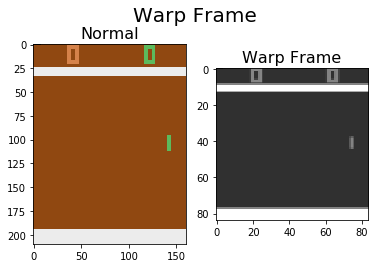

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

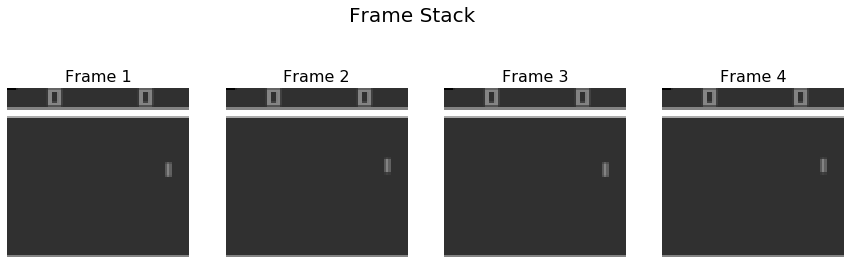

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [19]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

-18.0

# **Training des Agenten**

In [21]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    #TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0108 08:00:59.519789 140599736833856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: -20.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9953072715582952
Episode: 2 	Reward: -20.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9893953936677339
Episode: 3 	Reward: -21.0 	Mean: -20.33 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.984367621158428
Episode: 4 	Reward: -21.0 	Mean: -20.5 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9791548879197647
Episode: 5 	Reward: -19.0 	Mean: -20.2 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9728834247445128
Episode: 6 	Reward: -20.0 	Mean: -20.17 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9684533181504332
Episode: 7 	Reward: -20.0 	Mean: -20.14 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9618373279045124
Episode: 8 	Reward: -19.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9565028561237695
Episode: 9 	Reward: -21.0 	Mean: -20.11 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.9513289751839308
Episode: 10 	Reward: -21.0 	Mean: -20.2 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.946

Episode: 82 	Reward: -21.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.6162455457083952
Episode: 83 	Reward: -20.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.6122048300011952
Episode: 84 	Reward: -17.0 	Mean: -19.6 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.6071102206747812
Episode: 85 	Reward: -20.0 	Mean: -19.6 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.6032363875489181
Episode: 86 	Reward: -21.0 	Mean: -19.8 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.600327483930433
Episode: 87 	Reward: -21.0 	Mean: -19.9 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.596890556456077
Episode: 88 	Reward: -20.0 	Mean: -19.9 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.5931643914634053
Episode: 89 	Reward: -19.0 	Mean: -19.7 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.5888248532212278
Episode: 90 	Reward: -20.0 	Mean: -19.8 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.5843601275000341
Episode: 91 	Reward: -21.0 	Mean: -20.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0

Episode: 162 	Reward: -17.0 	Mean: -18.1 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.34328444541970554
Episode: 163 	Reward: -18.0 	Mean: -18.1 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.34026621495229487
Episode: 164 	Reward: -19.0 	Mean: -18.3 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.33671191388269894
Episode: 165 	Reward: -18.0 	Mean: -18.2 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.3342700259661089
Episode: 166 	Reward: -18.0 	Mean: -18.1 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.3314106850225463
Episode: 167 	Reward: -19.0 	Mean: -18.0 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.3286205632386675
Episode: 168 	Reward: -18.0 	Mean: -18.2 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.3256780951689544
Episode: 169 	Reward: -15.0 	Mean: -17.8 	BestMean: -18.0 	TRAIN START: True 	Epsi: 0.3218869385645097
Episode: 170 	Reward: -19.0 	Mean: -18.0 	BestMean: -17.8 	TRAIN START: True 	Epsi: 0.31927789954801916
Episode: 171 	Reward: -19.0 	Mean: -18.0 	BestMean: -17.8 	TRAIN STAR

Episode: 242 	Reward: -16.0 	Mean: -17.5 	BestMean: -17.6 	TRAIN START: True 	Epsi: 0.17234269746560263
Episode: 243 	Reward: -19.0 	Mean: -17.9 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.17077257440070007
Episode: 244 	Reward: -19.0 	Mean: -18.0 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16925146555143733
Episode: 245 	Reward: -16.0 	Mean: -17.8 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.1675891753388889
Episode: 246 	Reward: -18.0 	Mean: -17.6 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16606804454506235
Episode: 247 	Reward: -19.0 	Mean: -17.5 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16481434919097382
Episode: 248 	Reward: -17.0 	Mean: -17.6 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16336768751882116
Episode: 249 	Reward: -20.0 	Mean: -17.9 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16184466801683817
Episode: 250 	Reward: -20.0 	Mean: -18.2 	BestMean: -17.5 	TRAIN START: True 	Epsi: 0.16045576111231669
Episode: 251 	Reward: -19.0 	Mean: -18.3 	BestMean: -17.5 	TRAIN 

Episode: 321 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08360248689247929
Episode: 322 	Reward: -19.0 	Mean: -17.7 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08308938760612719
Episode: 323 	Reward: -14.0 	Mean: -17.1 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08232063380398731
Episode: 324 	Reward: -20.0 	Mean: -17.7 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08165119244917754
Episode: 325 	Reward: -17.0 	Mean: -17.6 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08099870117079738
Episode: 326 	Reward: -18.0 	Mean: -17.7 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.08035432267050888
Episode: 327 	Reward: -13.0 	Mean: -17.4 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.07949739747414429
Episode: 328 	Reward: -17.0 	Mean: -17.3 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.0785776117576098
Episode: 329 	Reward: -16.0 	Mean: -16.8 	BestMean: -16.0 	TRAIN START: True 	Epsi: 0.07769396478894014
Episode: 330 	Reward: -19.0 	Mean: -17.0 	BestMean: -16.0 	TRAIN 

Episode: 400 	Reward: -16.0 	Mean: -15.6 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04301744879727726
Episode: 401 	Reward: -14.0 	Mean: -15.9 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04272197622182355
Episode: 402 	Reward: -19.0 	Mean: -16.1 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04247700016862081
Episode: 403 	Reward: -15.0 	Mean: -15.8 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04215033391760935
Episode: 404 	Reward: -14.0 	Mean: -15.4 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04182710555797751
Episode: 405 	Reward: -17.0 	Mean: -15.6 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.041561138950532206
Episode: 406 	Reward: -18.0 	Mean: -16.0 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04133251792434231
Episode: 407 	Reward: -10.0 	Mean: -16.0 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.040894220124658424
Episode: 408 	Reward: -14.0 	Mean: -15.4 	BestMean: -15.2 	TRAIN START: True 	Epsi: 0.04058602755561974
Episode: 409 	Reward: -17.0 	Mean: -15.4 	BestMean: -15.2 	TRA

Episode: 479 	Reward: -14.0 	Mean: -16.1 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.027616923680129152
Episode: 480 	Reward: -11.0 	Mean: -15.6 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.027491226768728567
Episode: 481 	Reward: -19.0 	Mean: -15.7 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.0274132769251265
Episode: 482 	Reward: -19.0 	Mean: -16.1 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.02732426326483011
Episode: 483 	Reward: -10.0 	Mean: -16.1 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.02716818562487403
Episode: 484 	Reward: -15.0 	Mean: -15.6 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.027077725306319748
Episode: 485 	Reward: -19.0 	Mean: -15.8 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.027006039562218295
Episode: 486 	Reward: -15.0 	Mean: -15.7 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.026923023330332824
Episode: 487 	Reward: -19.0 	Mean: -15.7 	BestMean: -14.2 	TRAIN START: True 	Epsi: 0.026850711884813486
Episode: 488 	Reward: -15.0 	Mean: -15.6 	BestMean: -14.2 	

Episode: 558 	Reward: -9.0 	Mean: -14.3 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.02244545835512158
Episode: 559 	Reward: -19.0 	Mean: -14.8 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.022410592509054087
Episode: 560 	Reward: -18.0 	Mean: -15.0 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.022378696317062335
Episode: 561 	Reward: -17.0 	Mean: -15.4 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.02235196834612262
Episode: 562 	Reward: -15.0 	Mean: -15.2 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.022314960377091755
Episode: 563 	Reward: -20.0 	Mean: -15.5 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.02229174278971865
Episode: 564 	Reward: -16.0 	Mean: -15.2 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.022255998280993637
Episode: 565 	Reward: -13.0 	Mean: -15.3 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.022221033374667673
Episode: 566 	Reward: -10.0 	Mean: -15.4 	BestMean: -13.1 	TRAIN START: True 	Epsi: 0.02218206695406887
Episode: 567 	Reward: -17.0 	Mean: -15.4 	BestMean: -13.1 	T

Episode: 637 	Reward: -10.0 	Mean: -13.5 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02071490370167167
Episode: 638 	Reward: -18.0 	Mean: -14.2 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020705077587992428
Episode: 639 	Reward: -18.0 	Mean: -15.2 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020694733174765008
Episode: 640 	Reward: -8.0 	Mean: -15.0 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020681071879595805
Episode: 641 	Reward: -15.0 	Mean: -14.9 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02066812003509301
Episode: 642 	Reward: -14.0 	Mean: -14.7 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020656726634617414
Episode: 643 	Reward: -19.0 	Mean: -14.8 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02064977610561149
Episode: 644 	Reward: -13.0 	Mean: -14.9 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020638299654287075
Episode: 645 	Reward: -20.0 	Mean: -15.2 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02063212543695441
Episode: 646 	Reward: -12.0 	Mean: -14.7 	BestMean: -12.4 	T

Episode: 716 	Reward: -15.0 	Mean: -14.6 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02018953768129644
Episode: 717 	Reward: -17.0 	Mean: -14.8 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020186286879919215
Episode: 718 	Reward: -11.0 	Mean: -14.8 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020182733325191864
Episode: 719 	Reward: -14.0 	Mean: -15.2 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020179093470416024
Episode: 720 	Reward: -17.0 	Mean: -15.3 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02017621905479514
Episode: 721 	Reward: -14.0 	Mean: -15.1 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020172944001378867
Episode: 722 	Reward: -14.0 	Mean: -15.2 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02017029425468209
Episode: 723 	Reward: -5.0 	Mean: -13.9 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.020165920349455354
Episode: 724 	Reward: -15.0 	Mean: -13.8 	BestMean: -12.4 	TRAIN START: True 	Epsi: 0.02016355802995625
Episode: 725 	Reward: -11.0 	Mean: -13.3 	BestMean: -12.4 	T

Episode: 795 	Reward: -10.0 	Mean: -13.9 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.02004767598684268
Episode: 796 	Reward: -14.0 	Mean: -13.8 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020046899539218888
Episode: 797 	Reward: -11.0 	Mean: -13.5 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020045923081272714
Episode: 798 	Reward: -13.0 	Mean: -13.4 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020045210431727734
Episode: 799 	Reward: -18.0 	Mean: -14.3 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020044678296672065
Episode: 800 	Reward: -11.0 	Mean: -13.7 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020043934849817202
Episode: 801 	Reward: -16.0 	Mean: -13.8 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.02004329459717424
Episode: 802 	Reward: -14.0 	Mean: -13.8 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.02004255374437869
Episode: 803 	Reward: -6.0 	Mean: -12.6 	BestMean: -11.7 	TRAIN START: True 	Epsi: 0.020041604479869787
Episode: 804 	Reward: -14.0 	Mean: -12.7 	BestMean: -11.7 	

Episode: 874 	Reward: -14.0 	Mean: -13.6 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.02001250324049919
Episode: 875 	Reward: -14.0 	Mean: -13.7 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020012307734066218
Episode: 876 	Reward: -7.0 	Mean: -13.3 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020012041124718154
Episode: 877 	Reward: -15.0 	Mean: -13.2 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020011845971484248
Episode: 878 	Reward: -16.0 	Mean: -13.5 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020011653514993056
Episode: 879 	Reward: -11.0 	Mean: -13.3 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.02001144173746404
Episode: 880 	Reward: -9.0 	Mean: -12.8 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020011237403929325
Episode: 881 	Reward: -15.0 	Mean: -13.6 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.020011045331507115
Episode: 882 	Reward: -13.0 	Mean: -13.1 	BestMean: -10.9 	TRAIN START: True 	Epsi: 0.0200108519832429
Episode: 883 	Reward: -11.0 	Mean: -12.5 	BestMean: -10.9 	TR

Episode: 953 	Reward: -17.0 	Mean: -10.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020003090669860186
Episode: 954 	Reward: -15.0 	Mean: -10.5 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.0200030409435655
Episode: 955 	Reward: -14.0 	Mean: -11.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002985263001434
Episode: 956 	Reward: -9.0 	Mean: -11.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002921648029245
Episode: 957 	Reward: -11.0 	Mean: -11.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002872629609855
Episode: 958 	Reward: -9.0 	Mean: -10.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002811977157368
Episode: 959 	Reward: -12.0 	Mean: -12.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002762864076745
Episode: 960 	Reward: -15.0 	Mean: -12.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020002726306739615
Episode: 961 	Reward: -11.0 	Mean: -12.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000267911857539
Episode: 962 	Reward: -17.0 	Mean: -13.0 	BestMean: -9.0 	TRAIN START

Episode: 1032 	Reward: -14.0 	Mean: -13.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000776023753292
Episode: 1033 	Reward: -20.0 	Mean: -14.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000767365430803
Episode: 1034 	Reward: -8.0 	Mean: -13.7 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000075072779522
Episode: 1035 	Reward: -16.0 	Mean: -14.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000740127989206
Episode: 1036 	Reward: -10.0 	Mean: -13.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000072567563383
Episode: 1037 	Reward: -15.0 	Mean: -13.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000714728771116
Episode: 1038 	Reward: -11.0 	Mean: -13.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000701122855822
Episode: 1039 	Reward: -11.0 	Mean: -13.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000687941035215
Episode: 1040 	Reward: -16.0 	Mean: -13.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000676859101663
Episode: 1041 	Reward: -19.0 	Mean: -14.0 	BestMean: -9.0 

Episode: 1111 	Reward: -16.0 	Mean: -14.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000207386277592
Episode: 1112 	Reward: -16.0 	Mean: -14.7 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000020356454512
Episode: 1113 	Reward: -11.0 	Mean: -14.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000200093174315
Episode: 1114 	Reward: -15.0 	Mean: -14.1 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000196476558617
Episode: 1115 	Reward: -13.0 	Mean: -14.1 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000193578502842
Episode: 1116 	Reward: -12.0 	Mean: -14.0 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000190574487688
Episode: 1117 	Reward: -14.0 	Mean: -13.6 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000018766587662
Episode: 1118 	Reward: -12.0 	Mean: -13.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000018424439862
Episode: 1119 	Reward: -17.0 	Mean: -14.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000018116407813
Episode: 1120 	Reward: -13.0 	Mean: -13.9 	BestMean: -9.0 	

Episode: 1190 	Reward: -12.0 	Mean: -11.6 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.0200000528344336
Episode: 1191 	Reward: -7.0 	Mean: -11.5 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000051563967777
Episode: 1192 	Reward: -17.0 	Mean: -12.0 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000050921392985
Episode: 1193 	Reward: -12.0 	Mean: -12.3 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000004998200945
Episode: 1194 	Reward: -12.0 	Mean: -11.8 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000049014840992
Episode: 1195 	Reward: -16.0 	Mean: -12.7 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000048391449244
Episode: 1196 	Reward: -7.0 	Mean: -11.7 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000047346037445
Episode: 1197 	Reward: -15.0 	Mean: -12.2 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000046439162825
Episode: 1198 	Reward: -17.0 	Mean: -12.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.0200000457541789
Episode: 1199 	Reward: -14.0 	Mean: -12.9 	BestMean: -9.0 	TRA

Episode: 1269 	Reward: -12.0 	Mean: -11.8 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000012746581648
Episode: 1270 	Reward: -9.0 	Mean: -11.7 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000012509935012
Episode: 1271 	Reward: -2.0 	Mean: -10.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000012235029764
Episode: 1272 	Reward: -7.0 	Mean: -9.8 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000011961858504
Episode: 1273 	Reward: -13.0 	Mean: -9.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000011766813215
Episode: 1274 	Reward: -12.0 	Mean: -9.5 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.020000011559217025
Episode: 1275 	Reward: -2.0 	Mean: -8.4 	BestMean: -9.0 	TRAIN START: True 	Epsi: 0.02000001122207847
Episode: 1276 	Reward: -7.0 	Mean: -8.3 	BestMean: -8.4 	TRAIN START: True 	Epsi: 0.020000010971084496
Episode: 1277 	Reward: -12.0 	Mean: -8.6 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000010807314027
Episode: 1278 	Reward: -14.0 	Mean: -9.0 	BestMean: -8.3 	TRAIN STA

Episode: 1348 	Reward: -14.0 	Mean: -9.3 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002943157926
Episode: 1349 	Reward: -14.0 	Mean: -10.2 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002898006623
Episode: 1350 	Reward: -8.0 	Mean: -9.9 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.02000000283698858
Episode: 1351 	Reward: -6.0 	Mean: -9.6 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002775755966
Episode: 1352 	Reward: -4.0 	Mean: -10.1 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.02000000271237092
Episode: 1353 	Reward: -5.0 	Mean: -9.1 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002647201726
Episode: 1354 	Reward: -13.0 	Mean: -9.7 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002604089594
Episode: 1355 	Reward: -15.0 	Mean: -10.1 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002562755713
Episode: 1356 	Reward: -11.0 	Mean: -10.4 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000002514472724
Episode: 1357 	Reward: -14.0 	Mean: -10.4 	BestMean: -8.3 	TRAIN S

Episode: 1427 	Reward: -16.0 	Mean: -11.6 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000668474606
Episode: 1428 	Reward: -16.0 	Mean: -12.1 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000659194352
Episode: 1429 	Reward: -5.0 	Mean: -11.3 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.02000000064534071
Episode: 1430 	Reward: -9.0 	Mean: -11.5 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.02000000063187931
Episode: 1431 	Reward: 1.0 	Mean: -10.4 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000614899236
Episode: 1432 	Reward: -11.0 	Mean: -10.1 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000602458275
Episode: 1433 	Reward: -8.0 	Mean: -9.7 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000590103775
Episode: 1434 	Reward: -17.0 	Mean: -10.4 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.02000000057977402
Episode: 1435 	Reward: -12.0 	Mean: -10.7 	BestMean: -8.3 	TRAIN START: True 	Epsi: 0.020000000568089177
Episode: 1436 	Reward: -17.0 	Mean: -11.0 	BestMean: -8.3 	TRAIN

Episode: 1506 	Reward: -3.0 	Mean: -9.8 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.0200000001570114
Episode: 1507 	Reward: -1.0 	Mean: -9.0 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000153235876
Episode: 1508 	Reward: -15.0 	Mean: -9.3 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.02000000015075838
Episode: 1509 	Reward: -11.0 	Mean: -9.7 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000148086772
Episode: 1510 	Reward: -15.0 	Mean: -10.3 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000146302793
Episode: 1511 	Reward: -15.0 	Mean: -10.6 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000144064112
Episode: 1512 	Reward: -10.0 	Mean: -10.0 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000140965955
Episode: 1513 	Reward: -15.0 	Mean: -10.7 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.020000000139011744
Episode: 1514 	Reward: -10.0 	Mean: -11.0 	BestMean: -7.8 	TRAIN START: True 	Epsi: 0.02000000013646094
Episode: 1515 	Reward: -6.0 	Mean: -10.1 	BestMean: -7.8 	TRAIN S

Episode: 1586 	Reward: -15.0 	Mean: -9.4 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000034924845
Episode: 1587 	Reward: 2.0 	Mean: -8.4 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000034013532
Episode: 1588 	Reward: -11.0 	Mean: -8.7 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000033393407
Episode: 1589 	Reward: -4.0 	Mean: -8.1 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000032629552
Episode: 1590 	Reward: -13.0 	Mean: -8.6 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000032155338
Episode: 1591 	Reward: -5.0 	Mean: -7.9 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000031495303
Episode: 1592 	Reward: -6.0 	Mean: -7.8 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.020000000030704783
Episode: 1593 	Reward: -2.0 	Mean: -7.7 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.02000000003003125
Episode: 1594 	Reward: -9.0 	Mean: -8.0 	BestMean: -5.2 	TRAIN START: True 	Epsi: 0.02000000002949788
Episode: 1595 	Reward: -13.0 	Mean: -7.6 	BestMean: -5.2 	TRAIN START: Tr

Episode: 1666 	Reward: -11.0 	Mean: -10.5 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000007311426
Episode: 1667 	Reward: -7.0 	Mean: -9.8 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000007147755
Episode: 1668 	Reward: -16.0 	Mean: -11.0 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000007009026
Episode: 1669 	Reward: -4.0 	Mean: -10.2 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000006844727
Episode: 1670 	Reward: 5.0 	Mean: -8.0 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.0200000000067053
Episode: 1671 	Reward: -13.0 	Mean: -8.7 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000006582
Episode: 1672 	Reward: -3.0 	Mean: -8.6 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.02000000000642424
Episode: 1673 	Reward: -16.0 	Mean: -9.4 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000006326825
Episode: 1674 	Reward: -4.0 	Mean: -8.5 	BestMean: -3.4 	TRAIN START: True 	Epsi: 0.020000000006172466
Episode: 1675 	Reward: -11.0 	Mean: -8.0 	BestMean: -3.4 	TRAIN START: Tr

Episode: 1746 	Reward: -1.0 	Mean: -3.2 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001408603
Episode: 1747 	Reward: -11.0 	Mean: -2.9 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001381982
Episode: 1748 	Reward: -2.0 	Mean: -3.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001352207
Episode: 1749 	Reward: -18.0 	Mean: -5.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000133485
Episode: 1750 	Reward: -19.0 	Mean: -6.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001316267
Episode: 1751 	Reward: -2.0 	Mean: -5.5 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001287134
Episode: 1752 	Reward: -9.0 	Mean: -5.9 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001264173
Episode: 1753 	Reward: -15.0 	Mean: -8.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000001241077
Episode: 1754 	Reward: -3.0 	Mean: -8.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000121145
Episode: 1755 	Reward: -3.0 	Mean: -8.3 	BestMean: -0.1 	TRAIN START: T

Episode: 1826 	Reward: 3.0 	Mean: -4.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000028316
Episode: 1827 	Reward: -13.0 	Mean: -5.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000278195
Episode: 1828 	Reward: 0.0 	Mean: -3.5 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000271728
Episode: 1829 	Reward: -3.0 	Mean: -3.2 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000026561
Episode: 1830 	Reward: -2.0 	Mean: -4.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000259314
Episode: 1831 	Reward: -12.0 	Mean: -4.6 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000255116
Episode: 1832 	Reward: -9.0 	Mean: -5.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000025124
Episode: 1833 	Reward: -9.0 	Mean: -6.8 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000246657
Episode: 1834 	Reward: -13.0 	Mean: -7.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000024314
Episode: 1835 	Reward: -8.0 	Mean: -6.6 	BestMean: -0.1 	TRAIN START: True 	

Episode: 1906 	Reward: -6.0 	Mean: -5.5 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000005868
Episode: 1907 	Reward: 1.0 	Mean: -4.2 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.0200000000000574
Episode: 1908 	Reward: -11.0 	Mean: -5.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000056396
Episode: 1909 	Reward: -8.0 	Mean: -5.9 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000005523
Episode: 1910 	Reward: -5.0 	Mean: -5.2 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000054155
Episode: 1911 	Reward: -12.0 	Mean: -7.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000053322
Episode: 1912 	Reward: -11.0 	Mean: -7.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000052573
Episode: 1913 	Reward: 3.0 	Mean: -6.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000051425
Episode: 1914 	Reward: -3.0 	Mean: -6.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000050235
Episode: 1915 	Reward: -6.0 	Mean: -5.8 	BestMean: -0.1 	TRAIN START: True 	

Episode: 1986 	Reward: -2.0 	Mean: -3.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000011443
Episode: 1987 	Reward: -6.0 	Mean: -4.6 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000011224
Episode: 1988 	Reward: 3.0 	Mean: -3.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000010964
Episode: 1989 	Reward: -8.0 	Mean: -4.2 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000010735
Episode: 1990 	Reward: -4.0 	Mean: -3.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000010527
Episode: 1991 	Reward: -5.0 	Mean: -3.4 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000010246
Episode: 1992 	Reward: -1.0 	Mean: -3.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000001
Episode: 1993 	Reward: -8.0 	Mean: -4.5 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000009826
Episode: 1994 	Reward: -3.0 	Mean: -4.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000009593
Episode: 1995 	Reward: 1.0 	Mean: -3.3 	BestMean: -0.1 	TRAIN START: True 	Eps

Episode: 2066 	Reward: -9.0 	Mean: -3.3 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000002297
Episode: 2067 	Reward: 11.0 	Mean: -2.8 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000002256
Episode: 2068 	Reward: 2.0 	Mean: -2.9 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.0200000000000022
Episode: 2069 	Reward: 7.0 	Mean: -1.6 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000000216
Episode: 2070 	Reward: -7.0 	Mean: -1.1 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.020000000000002106
Episode: 2071 	Reward: -1.0 	Mean: 0.0 	BestMean: -0.1 	TRAIN START: True 	Epsi: 0.02000000000000205
Episode: 2072 	Reward: -8.0 	Mean: 0.6 	BestMean: 0.0 	TRAIN START: True 	Epsi: 0.020000000000002013
Episode: 2073 	Reward: 12.0 	Mean: 0.9 	BestMean: 0.6 	TRAIN START: True 	Epsi: 0.020000000000001975
Episode: 2074 	Reward: 11.0 	Mean: 3.6 	BestMean: 0.9 	TRAIN START: True 	Epsi: 0.02000000000000194
Episode: 2075 	Reward: -1.0 	Mean: 1.7 	BestMean: 3.6 	TRAIN START: True 	Epsi: 0.02000

Episode: 2148 	Reward: -11.0 	Mean: 2.6 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000406
Episode: 2149 	Reward: -10.0 	Mean: 2.0 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.0200000000000004
Episode: 2150 	Reward: 7.0 	Mean: 3.4 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000392
Episode: 2151 	Reward: -2.0 	Mean: 1.7 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000382
Episode: 2152 	Reward: -6.0 	Mean: 0.1 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.02000000000000037
Episode: 2153 	Reward: 6.0 	Mean: -0.2 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000365
Episode: 2154 	Reward: -7.0 	Mean: -1.6 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.02000000000000036
Episode: 2155 	Reward: -12.0 	Mean: -2.5 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000354
Episode: 2156 	Reward: -3.0 	Mean: -3.2 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.020000000000000347
Episode: 2157 	Reward: 4.0 	Mean: -3.4 	BestMean: 4.0 	TRAIN START: True 	Epsi: 0.02000000

Episode: 2230 	Reward: -1.0 	Mean: -2.2 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000077
Episode: 2231 	Reward: -12.0 	Mean: -4.4 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000077
Episode: 2232 	Reward: 2.0 	Mean: -3.5 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000073
Episode: 2233 	Reward: 5.0 	Mean: -2.8 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000073
Episode: 2234 	Reward: 3.0 	Mean: -2.3 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 2235 	Reward: 3.0 	Mean: -1.8 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 2236 	Reward: 2.0 	Mean: -1.6 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 2237 	Reward: 8.0 	Mean: -1.2 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 2238 	Reward: 5.0 	Mean: 0.5 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 2239 	Reward: 11.0 	Mean: 2.6 	BestMean: 4.8 	TRAIN START: True 	Epsi: 0.0200000000

Episode: 2312 	Reward: -6.0 	Mean: 6.6 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2313 	Reward: 9.0 	Mean: 6.6 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2314 	Reward: -10.0 	Mean: 4.8 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2315 	Reward: -12.0 	Mean: 2.4 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2316 	Reward: 9.0 	Mean: 2.5 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2317 	Reward: -16.0 	Mean: 0.4 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2318 	Reward: 11.0 	Mean: -0.6 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2319 	Reward: 7.0 	Mean: -0.2 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2320 	Reward: 6.0 	Mean: 0.5 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 2321 	Reward: 4.0 	Mean: 0.2 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000

Episode: 2394 	Reward: 11.0 	Mean: 5.5 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2395 	Reward: 0.0 	Mean: 4.9 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2396 	Reward: 12.0 	Mean: 5.2 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2397 	Reward: -4.0 	Mean: 4.9 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2398 	Reward: 9.0 	Mean: 6.0 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2399 	Reward: -1.0 	Mean: 5.1 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2400 	Reward: 4.0 	Mean: 5.3 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2401 	Reward: -4.0 	Mean: 4.4 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2402 	Reward: 4.0 	Mean: 3.8 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 2403 	Reward: 2.0 	Mean: 3.3 	BestMean: 8.0 	TRAIN START: True 	Epsi: 0.02000000000000

Episode: 2486 	Reward: -7.0 	Mean: -1.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2487 	Reward: -10.0 	Mean: -2.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2488 	Reward: 4.0 	Mean: -1.1 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2489 	Reward: 3.0 	Mean: -0.5 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2490 	Reward: -4.0 	Mean: -1.3 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2491 	Reward: 14.0 	Mean: 1.0 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2492 	Reward: 9.0 	Mean: 3.0 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2493 	Reward: 3.0 	Mean: 2.3 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2494 	Reward: 8.0 	Mean: 2.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2495 	Reward: 0.0 	Mean: 2.0 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2496 	Reward: 8.0 	Mean: 3.5 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2497 	Reward: 5.0 	Mean: 5.0 	BestMean: 9.0 	TRAIN START:

Episode: 2583 	Reward: -3.0 	Mean: 3.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2584 	Reward: 14.0 	Mean: 5.4 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2585 	Reward: 9.0 	Mean: 5.7 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2586 	Reward: 4.0 	Mean: 5.7 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2587 	Reward: 6.0 	Mean: 6.7 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2588 	Reward: 4.0 	Mean: 6.7 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2589 	Reward: -6.0 	Mean: 4.3 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2590 	Reward: 8.0 	Mean: 5.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2591 	Reward: -12.0 	Mean: 3.3 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2592 	Reward: -4.0 	Mean: 2.0 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2593 	Reward: 18.0 	Mean: 4.1 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2594 	Reward: 12.0 	Mean: 3.9 	BestMean: 9.0 	TRAIN START: T

Episode: 2680 	Reward: 6.0 	Mean: 2.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2681 	Reward: -2.0 	Mean: 1.6 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2682 	Reward: 9.0 	Mean: 2.5 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2683 	Reward: -12.0 	Mean: 0.5 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2684 	Reward: 7.0 	Mean: 0.3 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2685 	Reward: -16.0 	Mean: -2.8 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2686 	Reward: 5.0 	Mean: -0.8 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2687 	Reward: 6.0 	Mean: 0.9 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2688 	Reward: 2.0 	Mean: 0.4 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2689 	Reward: 13.0 	Mean: 1.8 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2690 	Reward: -1.0 	Mean: 1.1 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2691 	Reward: 9.0 	Mean: 2.2 	BestMean: 9.0 	TRAIN START: 

Episode: 2777 	Reward: 11.0 	Mean: 1.9 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2778 	Reward: 5.0 	Mean: 2.8 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2779 	Reward: 11.0 	Mean: 4.4 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2780 	Reward: -9.0 	Mean: 4.1 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2781 	Reward: -2.0 	Mean: 2.9 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2782 	Reward: 5.0 	Mean: 2.8 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2783 	Reward: -4.0 	Mean: 1.3 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2784 	Reward: 10.0 	Mean: 3.1 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2785 	Reward: 8.0 	Mean: 2.9 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2786 	Reward: 4.0 	Mean: 3.9 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2787 	Reward: 11.0 	Mean: 3.9 	BestMean: 9.4 	TRAIN START: True 	Epsi: 0.02
Episode: 2788 	Reward: 10.0 	Mean: 4.4 	BestMean: 9.4 	TRAIN START: T

Episode: 2874 	Reward: 14.0 	Mean: 12.0 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.02
Episode: 2875 	Reward: 9.0 	Mean: 11.7 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2876 	Reward: 8.0 	Mean: 12.0 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2877 	Reward: -2.0 	Mean: 10.7 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2878 	Reward: 11.0 	Mean: 10.0 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2879 	Reward: -1.0 	Mean: 8.6 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2880 	Reward: -14.0 	Mean: 5.2 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2881 	Reward: -12.0 	Mean: 3.5 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2882 	Reward: 6.0 	Mean: 3.7 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2883 	Reward: 15.0 	Mean: 3.4 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2884 	Reward: 5.0 	Mean: 2.5 	BestMean: 12.0 	TRAIN START: True 	Epsi: 0.02
Episode: 2885 	Reward: 13.0 	Mean: 2.9 	BestMean: 1

Episode: 2970 	Reward: 4.0 	Mean: 3.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2971 	Reward: 17.0 	Mean: 5.2 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2972 	Reward: 13.0 	Mean: 5.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2973 	Reward: 14.0 	Mean: 6.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2974 	Reward: 9.0 	Mean: 7.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2975 	Reward: 14.0 	Mean: 9.8 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2976 	Reward: 5.0 	Mean: 9.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2977 	Reward: 9.0 	Mean: 9.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2978 	Reward: 15.0 	Mean: 10.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2979 	Reward: 14.0 	Mean: 11.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2980 	Reward: -5.0 	Mean: 10.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 2981 	Reward: -3.0 	Mean: 8.5 	BestMean: 12.7 

Episode: 3066 	Reward: -7.0 	Mean: 8.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3067 	Reward: 11.0 	Mean: 8.3 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3068 	Reward: 13.0 	Mean: 9.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3069 	Reward: 6.0 	Mean: 9.3 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3070 	Reward: 13.0 	Mean: 9.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3071 	Reward: 5.0 	Mean: 8.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3072 	Reward: -2.0 	Mean: 6.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3073 	Reward: -2.0 	Mean: 6.2 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3074 	Reward: 5.0 	Mean: 5.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3075 	Reward: 15.0 	Mean: 5.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3076 	Reward: -8.0 	Mean: 5.6 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3077 	Reward: -2.0 	Mean: 4.3 	BestMean: 12.7 	T

Episode: 3162 	Reward: 20.0 	Mean: 10.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3163 	Reward: 3.0 	Mean: 9.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3164 	Reward: 0.0 	Mean: 7.6 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3165 	Reward: 12.0 	Mean: 6.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3166 	Reward: 14.0 	Mean: 6.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3167 	Reward: 15.0 	Mean: 9.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3168 	Reward: 9.0 	Mean: 8.8 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3169 	Reward: -1.0 	Mean: 9.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3170 	Reward: 21.0 	Mean: 10.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3171 	Reward: 16.0 	Mean: 10.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3172 	Reward: -9.0 	Mean: 8.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3173 	Reward: 9.0 	Mean: 8.6 	BestMean: 12.7 

Episode: 3258 	Reward: 9.0 	Mean: 4.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3259 	Reward: -12.0 	Mean: 2.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3260 	Reward: -1.0 	Mean: 1.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3261 	Reward: 5.0 	Mean: 0.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3262 	Reward: 15.0 	Mean: 1.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3263 	Reward: -15.0 	Mean: -0.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3264 	Reward: 5.0 	Mean: 1.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3265 	Reward: 15.0 	Mean: 1.2 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3266 	Reward: -2.0 	Mean: 1.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3267 	Reward: 21.0 	Mean: 4.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3268 	Reward: -1.0 	Mean: 3.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3269 	Reward: 5.0 	Mean: 4.7 	BestMean: 12.7 

Episode: 3356 	Reward: -5.0 	Mean: 0.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3357 	Reward: 14.0 	Mean: 1.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3358 	Reward: -3.0 	Mean: 2.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3359 	Reward: 0.0 	Mean: 2.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3360 	Reward: -6.0 	Mean: 1.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3361 	Reward: -6.0 	Mean: 0.5 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3362 	Reward: 14.0 	Mean: 2.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3363 	Reward: 6.0 	Mean: 2.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3364 	Reward: 6.0 	Mean: 1.2 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3365 	Reward: 3.0 	Mean: 2.3 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3366 	Reward: 6.0 	Mean: 3.4 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3367 	Reward: 2.0 	Mean: 2.2 	BestMean: 12.7 	TRAI

Episode: 3452 	Reward: -14.0 	Mean: 6.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3453 	Reward: 0.0 	Mean: 5.0 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3454 	Reward: -2.0 	Mean: 4.3 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3455 	Reward: 13.0 	Mean: 3.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3456 	Reward: 14.0 	Mean: 4.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3457 	Reward: -14.0 	Mean: 1.8 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3458 	Reward: -1.0 	Mean: 0.8 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3459 	Reward: 16.0 	Mean: 2.1 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3460 	Reward: 14.0 	Mean: 3.7 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3461 	Reward: 0.0 	Mean: 2.6 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3462 	Reward: 19.0 	Mean: 5.9 	BestMean: 12.7 	TRAIN START: True 	Epsi: 0.02
Episode: 3463 	Reward: 9.0 	Mean: 6.8 	BestMean: 12.7 

Episode: 3548 	Reward: 7.0 	Mean: 4.7 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3549 	Reward: -1.0 	Mean: 5.2 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3550 	Reward: 9.0 	Mean: 4.6 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3551 	Reward: 14.0 	Mean: 5.7 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3552 	Reward: 20.0 	Mean: 8.3 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3553 	Reward: 6.0 	Mean: 7.9 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3554 	Reward: 9.0 	Mean: 7.7 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3555 	Reward: 6.0 	Mean: 6.8 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3556 	Reward: 8.0 	Mean: 6.8 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3557 	Reward: -1.0 	Mean: 7.7 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3558 	Reward: 10.0 	Mean: 8.0 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3559 	Reward: 7.0 	Mean: 8.8 	BestMean: 13.2 	TRAIN

Episode: 3644 	Reward: 16.0 	Mean: 9.6 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3645 	Reward: 15.0 	Mean: 10.1 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3646 	Reward: 8.0 	Mean: 11.0 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3647 	Reward: 9.0 	Mean: 9.9 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3648 	Reward: 15.0 	Mean: 11.3 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3649 	Reward: 15.0 	Mean: 12.8 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3650 	Reward: 8.0 	Mean: 12.5 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3651 	Reward: 14.0 	Mean: 13.1 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3652 	Reward: 18.0 	Mean: 13.0 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3653 	Reward: 5.0 	Mean: 12.3 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3654 	Reward: -6.0 	Mean: 10.1 	BestMean: 13.2 	TRAIN START: True 	Epsi: 0.02
Episode: 3655 	Reward: -3.0 	Mean: 8.3 	BestMean:

Episode: 3740 	Reward: 6.0 	Mean: 5.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3741 	Reward: 3.0 	Mean: 4.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3742 	Reward: 13.0 	Mean: 3.9 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3743 	Reward: -1.0 	Mean: 2.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3744 	Reward: 7.0 	Mean: 1.9 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3745 	Reward: -7.0 	Mean: 0.6 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3746 	Reward: 8.0 	Mean: 2.9 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3747 	Reward: 17.0 	Mean: 4.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3748 	Reward: -7.0 	Mean: 2.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3749 	Reward: 8.0 	Mean: 4.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3750 	Reward: -2.0 	Mean: 3.9 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3751 	Reward: 8.0 	Mean: 4.4 	BestMean: 13.4 	TRAI

Episode: 3836 	Reward: 8.0 	Mean: 5.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3837 	Reward: 14.0 	Mean: 6.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3838 	Reward: 9.0 	Mean: 6.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3839 	Reward: 18.0 	Mean: 7.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3840 	Reward: 13.0 	Mean: 8.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3841 	Reward: 3.0 	Mean: 8.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3842 	Reward: -1.0 	Mean: 8.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3843 	Reward: 13.0 	Mean: 8.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3844 	Reward: 2.0 	Mean: 7.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3845 	Reward: 15.0 	Mean: 9.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3846 	Reward: 7.0 	Mean: 9.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3847 	Reward: -1.0 	Mean: 7.8 	BestMean: 13.4 	TRA

Episode: 3932 	Reward: -10.0 	Mean: -1.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3933 	Reward: 13.0 	Mean: 0.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3934 	Reward: -7.0 	Mean: -0.9 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3935 	Reward: -11.0 	Mean: -1.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3936 	Reward: 11.0 	Mean: -0.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3937 	Reward: -2.0 	Mean: -1.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3938 	Reward: 8.0 	Mean: 0.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3939 	Reward: 12.0 	Mean: 2.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3940 	Reward: -1.0 	Mean: 2.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3941 	Reward: 17.0 	Mean: 3.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3942 	Reward: 13.0 	Mean: 5.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 3943 	Reward: 17.0 	Mean: 5.7 	BestMean

Episode: 4030 	Reward: -11.0 	Mean: 7.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4031 	Reward: 19.0 	Mean: 8.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4032 	Reward: 19.0 	Mean: 9.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4033 	Reward: 5.0 	Mean: 9.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4034 	Reward: 13.0 	Mean: 9.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4035 	Reward: 11.0 	Mean: 9.6 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4036 	Reward: 14.0 	Mean: 10.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4037 	Reward: -9.0 	Mean: 9.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4038 	Reward: 6.0 	Mean: 8.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4039 	Reward: 16.0 	Mean: 8.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4040 	Reward: 8.0 	Mean: 10.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4041 	Reward: -6.0 	Mean: 7.7 	BestMean: 13.4

Episode: 4126 	Reward: 3.0 	Mean: 6.6 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4127 	Reward: 2.0 	Mean: 5.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4128 	Reward: -7.0 	Mean: 4.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4129 	Reward: 18.0 	Mean: 5.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4130 	Reward: 6.0 	Mean: 4.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4131 	Reward: 14.0 	Mean: 6.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4132 	Reward: 1.0 	Mean: 5.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4133 	Reward: -2.0 	Mean: 4.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4134 	Reward: 18.0 	Mean: 5.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4135 	Reward: 19.0 	Mean: 7.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4136 	Reward: 4.0 	Mean: 7.3 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4137 	Reward: 13.0 	Mean: 8.4 	BestMean: 13.4 	TRA

Episode: 4222 	Reward: -6.0 	Mean: 5.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4223 	Reward: 0.0 	Mean: 4.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4224 	Reward: 14.0 	Mean: 4.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4225 	Reward: 6.0 	Mean: 5.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4226 	Reward: 16.0 	Mean: 5.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4227 	Reward: 9.0 	Mean: 6.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4228 	Reward: 2.0 	Mean: 5.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4229 	Reward: 17.0 	Mean: 7.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4230 	Reward: 7.0 	Mean: 7.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4231 	Reward: -4.0 	Mean: 6.1 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4232 	Reward: -13.0 	Mean: 5.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4233 	Reward: 9.0 	Mean: 6.3 	BestMean: 13.4 	TRA

Episode: 4318 	Reward: 8.0 	Mean: 9.6 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4319 	Reward: 0.0 	Mean: 8.2 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4320 	Reward: 4.0 	Mean: 8.0 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4321 	Reward: 2.0 	Mean: 6.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4322 	Reward: 8.0 	Mean: 6.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4323 	Reward: -10.0 	Mean: 4.8 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4324 	Reward: 4.0 	Mean: 3.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4325 	Reward: 17.0 	Mean: 4.7 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4326 	Reward: 14.0 	Mean: 5.5 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4327 	Reward: -3.0 	Mean: 4.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4328 	Reward: 8.0 	Mean: 4.4 	BestMean: 13.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4329 	Reward: 4.0 	Mean: 4.8 	BestMean: 13.4 	TRAIN

Episode: 4414 	Reward: 8.0 	Mean: 12.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4415 	Reward: 6.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4416 	Reward: 13.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4417 	Reward: 9.0 	Mean: 12.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4418 	Reward: 5.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4419 	Reward: 8.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4420 	Reward: -2.0 	Mean: 8.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4421 	Reward: 7.0 	Mean: 7.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4422 	Reward: -1.0 	Mean: 6.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4423 	Reward: 0.0 	Mean: 5.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4424 	Reward: -1.0 	Mean: 4.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4425 	Reward: 17.0 	Mean: 5.5 	BestMean: 13.7 

Episode: 4510 	Reward: -8.0 	Mean: 7.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4511 	Reward: 6.0 	Mean: 7.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4512 	Reward: 13.0 	Mean: 8.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4513 	Reward: 9.0 	Mean: 7.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4514 	Reward: -7.0 	Mean: 5.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4515 	Reward: 11.0 	Mean: 4.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4516 	Reward: 4.0 	Mean: 4.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4517 	Reward: 15.0 	Mean: 6.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4518 	Reward: 17.0 	Mean: 6.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4519 	Reward: 14.0 	Mean: 7.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4520 	Reward: 14.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4521 	Reward: 8.0 	Mean: 9.8 	BestMean: 13.7 	TR

Episode: 4606 	Reward: 11.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4607 	Reward: 15.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4608 	Reward: 16.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4609 	Reward: 9.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4610 	Reward: 11.0 	Mean: 11.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4611 	Reward: -5.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4612 	Reward: 17.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4613 	Reward: 10.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4614 	Reward: 16.0 	Mean: 10.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4615 	Reward: 21.0 	Mean: 12.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4616 	Reward: 6.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4617 	Reward: -7.0 	Mean: 9.4 	BestMe

Episode: 4702 	Reward: 11.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4703 	Reward: 12.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4704 	Reward: -2.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4705 	Reward: 17.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4706 	Reward: -1.0 	Mean: 8.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4707 	Reward: -6.0 	Mean: 6.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4708 	Reward: 12.0 	Mean: 6.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4709 	Reward: 12.0 	Mean: 7.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4710 	Reward: -1.0 	Mean: 6.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4711 	Reward: -9.0 	Mean: 4.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4712 	Reward: 8.0 	Mean: 4.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02
Episode: 4713 	Reward: 7.0 	Mean: 3.7 	BestMean: 13

Episode: 4798 	Reward: 8.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4799 	Reward: 7.0 	Mean: 7.3 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4800 	Reward: 16.0 	Mean: 8.1 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4801 	Reward: 12.0 	Mean: 7.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4802 	Reward: 18.0 	Mean: 10.7 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4803 	Reward: 18.0 	Mean: 11.2 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4804 	Reward: 16.0 	Mean: 11.8 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4805 	Reward: 17.0 	Mean: 11.9 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4806 	Reward: 6.0 	Mean: 11.4 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4807 	Reward: 8.0 	Mean: 12.6 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4808 	Reward: 17.0 	Mean: 13.5 	BestMean: 14.0 	TRAIN START: True 	Epsi: 0.02
Episode: 4809 	Reward: 5.0 	Mean: 13.3 	BestMean: 1

Episode: 4894 	Reward: 15.0 	Mean: 12.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4895 	Reward: 16.0 	Mean: 13.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4896 	Reward: 12.0 	Mean: 13.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4897 	Reward: 15.0 	Mean: 14.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4898 	Reward: 12.0 	Mean: 13.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4899 	Reward: 18.0 	Mean: 13.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4900 	Reward: 7.0 	Mean: 12.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4901 	Reward: 5.0 	Mean: 11.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4902 	Reward: 14.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4903 	Reward: 3.0 	Mean: 11.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4904 	Reward: 16.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4905 	Reward: 19.0 	Mean: 12.1 	BestM

Episode: 4990 	Reward: -10.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4991 	Reward: 15.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4992 	Reward: 12.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4993 	Reward: 18.0 	Mean: 11.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4994 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4995 	Reward: 7.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4996 	Reward: 9.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4997 	Reward: 13.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4998 	Reward: 0.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 4999 	Reward: -10.0 	Mean: 6.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5000 	Reward: 8.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5001 	Reward: 12.0 	Mean: 7.9 	BestMean: 15.

Episode: 5086 	Reward: -2.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5087 	Reward: 15.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5088 	Reward: 8.0 	Mean: 11.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5089 	Reward: 14.0 	Mean: 11.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5090 	Reward: 14.0 	Mean: 13.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5091 	Reward: 4.0 	Mean: 11.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5092 	Reward: -4.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5093 	Reward: 11.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5094 	Reward: 7.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5095 	Reward: 7.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5096 	Reward: 17.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5097 	Reward: 10.0 	Mean: 8.8 	BestMean: 15.

Episode: 5182 	Reward: -2.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5183 	Reward: -9.0 	Mean: 1.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5184 	Reward: 4.0 	Mean: 2.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5185 	Reward: 15.0 	Mean: 3.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5186 	Reward: 4.0 	Mean: 3.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5187 	Reward: 12.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5188 	Reward: 20.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5189 	Reward: 9.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5190 	Reward: 14.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5191 	Reward: 11.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5192 	Reward: -5.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5193 	Reward: 18.0 	Mean: 10.2 	BestMean: 15.4 	

Episode: 5279 	Reward: 15.0 	Mean: 11.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5280 	Reward: 16.0 	Mean: 11.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5281 	Reward: 4.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5282 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5283 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5284 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5285 	Reward: -7.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5286 	Reward: 11.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5287 	Reward: 18.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5288 	Reward: 4.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5289 	Reward: 11.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5290 	Reward: 18.0 	Mean: 8.7 	BestMean: 1

Episode: 5375 	Reward: 13.0 	Mean: 2.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5376 	Reward: 8.0 	Mean: 3.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5377 	Reward: -4.0 	Mean: 2.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5378 	Reward: 13.0 	Mean: 4.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5379 	Reward: 17.0 	Mean: 5.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5380 	Reward: 16.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5381 	Reward: 7.0 	Mean: 9.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5382 	Reward: 6.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5383 	Reward: 6.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5384 	Reward: 12.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5385 	Reward: 19.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5386 	Reward: 10.0 	Mean: 10.2 	BestMean: 15.4 	

Episode: 5471 	Reward: -4.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5472 	Reward: 12.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5473 	Reward: 7.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5474 	Reward: 4.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5475 	Reward: 12.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5476 	Reward: 15.0 	Mean: 8.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5477 	Reward: 7.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5478 	Reward: 8.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5479 	Reward: -9.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5480 	Reward: 7.0 	Mean: 5.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5481 	Reward: 0.0 	Mean: 6.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5482 	Reward: -12.0 	Mean: 3.9 	BestMean: 15.4 	T

Episode: 5567 	Reward: 8.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5568 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5569 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5570 	Reward: 13.0 	Mean: 11.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5571 	Reward: 15.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5572 	Reward: -7.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5573 	Reward: 11.0 	Mean: 9.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5574 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5575 	Reward: 9.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5576 	Reward: 16.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5577 	Reward: 14.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5578 	Reward: 16.0 	Mean: 11.1 	BestMean

Episode: 5663 	Reward: 18.0 	Mean: 2.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5664 	Reward: 9.0 	Mean: 4.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5665 	Reward: 14.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5666 	Reward: 16.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5667 	Reward: -5.0 	Mean: 6.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5668 	Reward: 13.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5669 	Reward: 10.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5670 	Reward: 10.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5671 	Reward: 19.0 	Mean: 10.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5672 	Reward: -5.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5673 	Reward: 4.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5674 	Reward: 9.0 	Mean: 8.5 	BestMean: 15.4 	

Episode: 5759 	Reward: 3.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5760 	Reward: 3.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5761 	Reward: 9.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5762 	Reward: 14.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5763 	Reward: 14.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5764 	Reward: 14.0 	Mean: 9.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5765 	Reward: 15.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5766 	Reward: 14.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5767 	Reward: 8.0 	Mean: 10.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5768 	Reward: 5.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5769 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5770 	Reward: 14.0 	Mean: 11.9 	BestMean: 15

Episode: 5855 	Reward: 9.0 	Mean: 3.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5856 	Reward: 7.0 	Mean: 3.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5857 	Reward: 11.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5858 	Reward: -2.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5859 	Reward: 11.0 	Mean: 6.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5860 	Reward: 12.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5861 	Reward: -8.0 	Mean: 3.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5862 	Reward: -4.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5863 	Reward: 12.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5864 	Reward: 10.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5865 	Reward: 10.0 	Mean: 5.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5866 	Reward: -4.0 	Mean: 4.8 	BestMean: 15.4 	

Episode: 5951 	Reward: 13.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5952 	Reward: -4.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5953 	Reward: 2.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5954 	Reward: 10.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5955 	Reward: 16.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5956 	Reward: 17.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5957 	Reward: 11.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5958 	Reward: 8.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5959 	Reward: 13.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5960 	Reward: 19.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5961 	Reward: 17.0 	Mean: 10.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 5962 	Reward: 2.0 	Mean: 11.5 	BestMean: 15.4

Episode: 6047 	Reward: 2.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6048 	Reward: 17.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6049 	Reward: 14.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6050 	Reward: 7.0 	Mean: 7.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6051 	Reward: 7.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6052 	Reward: 15.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6053 	Reward: 12.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6054 	Reward: 12.0 	Mean: 9.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6055 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6056 	Reward: 20.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6057 	Reward: 11.0 	Mean: 12.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6058 	Reward: 8.0 	Mean: 11.8 	BestMean: 15.4

Episode: 6143 	Reward: 11.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6144 	Reward: 13.0 	Mean: 9.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6145 	Reward: 10.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6146 	Reward: -1.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6147 	Reward: 18.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6148 	Reward: 18.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6149 	Reward: 20.0 	Mean: 11.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6150 	Reward: 16.0 	Mean: 12.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6151 	Reward: 4.0 	Mean: 11.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6152 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6153 	Reward: 18.0 	Mean: 12.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6154 	Reward: 19.0 	Mean: 13.4 	BestMe

Episode: 6239 	Reward: 6.0 	Mean: 2.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6240 	Reward: 7.0 	Mean: 3.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6241 	Reward: -9.0 	Mean: 4.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6242 	Reward: 13.0 	Mean: 3.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6243 	Reward: -13.0 	Mean: 1.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6244 	Reward: 3.0 	Mean: 1.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6245 	Reward: 10.0 	Mean: 1.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6246 	Reward: 5.0 	Mean: 1.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6247 	Reward: 14.0 	Mean: 2.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6248 	Reward: 14.0 	Mean: 5.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6249 	Reward: 2.0 	Mean: 4.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6250 	Reward: 1.0 	Mean: 4.0 	BestMean: 15.4 	TRA

Episode: 6335 	Reward: 17.0 	Mean: 5.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6336 	Reward: 10.0 	Mean: 5.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6337 	Reward: 4.0 	Mean: 5.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6338 	Reward: 10.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6339 	Reward: 8.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6340 	Reward: -2.0 	Mean: 6.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6341 	Reward: 10.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6342 	Reward: 2.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6343 	Reward: 4.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6344 	Reward: 12.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6345 	Reward: 13.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6346 	Reward: 13.0 	Mean: 7.4 	BestMean: 15.4 	TR

Episode: 6431 	Reward: 11.0 	Mean: 6.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6432 	Reward: -9.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6433 	Reward: 14.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6434 	Reward: 17.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6435 	Reward: 18.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6436 	Reward: 17.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6437 	Reward: 18.0 	Mean: 11.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6438 	Reward: 14.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6439 	Reward: -3.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6440 	Reward: 6.0 	Mean: 10.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6441 	Reward: -5.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6442 	Reward: 15.0 	Mean: 11.1 	BestMean

Episode: 6527 	Reward: 13.0 	Mean: 5.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6528 	Reward: 16.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6529 	Reward: 17.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6530 	Reward: 20.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6531 	Reward: 14.0 	Mean: 11.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6532 	Reward: 9.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6533 	Reward: 4.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6534 	Reward: 16.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6535 	Reward: 2.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6536 	Reward: 14.0 	Mean: 12.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6537 	Reward: 19.0 	Mean: 13.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6538 	Reward: 9.0 	Mean: 12.4 	BestMean: 1

Episode: 6623 	Reward: 2.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6624 	Reward: 6.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6625 	Reward: 18.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6626 	Reward: 14.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6627 	Reward: 12.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6628 	Reward: 14.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6629 	Reward: 5.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6630 	Reward: -5.0 	Mean: 7.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6631 	Reward: 16.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6632 	Reward: 0.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6633 	Reward: 9.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6634 	Reward: 18.0 	Mean: 10.1 	BestMean: 15.4 	TR

Episode: 6719 	Reward: 18.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6720 	Reward: -1.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6721 	Reward: 15.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6722 	Reward: -6.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6723 	Reward: 6.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6724 	Reward: 11.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6725 	Reward: 12.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6726 	Reward: 3.0 	Mean: 6.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6727 	Reward: -3.0 	Mean: 6.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6728 	Reward: 5.0 	Mean: 6.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6729 	Reward: 9.0 	Mean: 5.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6730 	Reward: 0.0 	Mean: 5.2 	BestMean: 15.4 	TRA

Episode: 6815 	Reward: 17.0 	Mean: 3.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6816 	Reward: 13.0 	Mean: 3.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6817 	Reward: 4.0 	Mean: 3.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6818 	Reward: -2.0 	Mean: 2.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6819 	Reward: 10.0 	Mean: 4.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6820 	Reward: 7.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6821 	Reward: 11.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6822 	Reward: 11.0 	Mean: 7.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6823 	Reward: 8.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6824 	Reward: 18.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6825 	Reward: 7.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6826 	Reward: 7.0 	Mean: 8.1 	BestMean: 15.4 	TRA

Episode: 6911 	Reward: 2.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6912 	Reward: 10.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6913 	Reward: 18.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6914 	Reward: 12.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6915 	Reward: 14.0 	Mean: 11.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6916 	Reward: -6.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6917 	Reward: 19.0 	Mean: 10.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6918 	Reward: 19.0 	Mean: 11.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6919 	Reward: 13.0 	Mean: 11.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6920 	Reward: 21.0 	Mean: 12.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6921 	Reward: 3.0 	Mean: 12.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 6922 	Reward: 14.0 	Mean: 12.7 	BestMea

Episode: 7007 	Reward: 17.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7008 	Reward: 16.0 	Mean: 11.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7009 	Reward: 10.0 	Mean: 11.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7010 	Reward: 9.0 	Mean: 11.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7011 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7012 	Reward: 14.0 	Mean: 12.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7013 	Reward: 17.0 	Mean: 14.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7014 	Reward: 10.0 	Mean: 13.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7015 	Reward: 5.0 	Mean: 12.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7016 	Reward: 10.0 	Mean: 12.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7017 	Reward: 13.0 	Mean: 11.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7018 	Reward: 15.0 	Mean: 11.5 	Best

Episode: 7103 	Reward: 10.0 	Mean: 9.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7104 	Reward: 16.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7105 	Reward: 9.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7106 	Reward: 19.0 	Mean: 11.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7107 	Reward: 14.0 	Mean: 10.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7108 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7109 	Reward: -4.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7110 	Reward: 20.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7111 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7112 	Reward: 9.0 	Mean: 11.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7113 	Reward: 0.0 	Mean: 10.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7114 	Reward: 12.0 	Mean: 9.6 	BestMean: 

Episode: 7199 	Reward: 18.0 	Mean: 11.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7200 	Reward: 12.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7201 	Reward: 14.0 	Mean: 10.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7202 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7203 	Reward: 16.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7204 	Reward: -12.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7205 	Reward: -4.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7206 	Reward: -2.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7207 	Reward: -11.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7208 	Reward: 14.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7209 	Reward: 16.0 	Mean: 5.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7210 	Reward: 19.0 	Mean: 5.9 	BestMean

Episode: 7295 	Reward: 13.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7296 	Reward: 11.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7297 	Reward: 13.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7298 	Reward: 11.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7299 	Reward: 16.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7300 	Reward: 13.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7301 	Reward: -5.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7302 	Reward: 21.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7303 	Reward: 5.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7304 	Reward: -2.0 	Mean: 9.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7305 	Reward: 11.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7306 	Reward: -3.0 	Mean: 8.0 	BestMean: 1

Episode: 7391 	Reward: -17.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7392 	Reward: 8.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7393 	Reward: -1.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7394 	Reward: 12.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7395 	Reward: -6.0 	Mean: 4.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7396 	Reward: 13.0 	Mean: 4.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7397 	Reward: 14.0 	Mean: 5.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7398 	Reward: -5.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7399 	Reward: 8.0 	Mean: 3.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7400 	Reward: 11.0 	Mean: 3.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7401 	Reward: 2.0 	Mean: 5.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7402 	Reward: 3.0 	Mean: 5.1 	BestMean: 15.4 	T

Episode: 7487 	Reward: 3.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7488 	Reward: -1.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7489 	Reward: 7.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7490 	Reward: 15.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7491 	Reward: 13.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7492 	Reward: -1.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7493 	Reward: 13.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7494 	Reward: 12.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7495 	Reward: 4.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7496 	Reward: 16.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7497 	Reward: 4.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7498 	Reward: 3.0 	Mean: 8.6 	BestMean: 15.4 	TRA

Episode: 7583 	Reward: 9.0 	Mean: 2.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7584 	Reward: 15.0 	Mean: 4.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7585 	Reward: 1.0 	Mean: 5.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7586 	Reward: 0.0 	Mean: 5.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7587 	Reward: 3.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7588 	Reward: 16.0 	Mean: 6.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7589 	Reward: 12.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7590 	Reward: -2.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7591 	Reward: 5.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7592 	Reward: 9.0 	Mean: 6.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7593 	Reward: 18.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7594 	Reward: 7.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN

Episode: 7679 	Reward: 10.0 	Mean: 3.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7680 	Reward: 5.0 	Mean: 2.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7681 	Reward: 18.0 	Mean: 4.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7682 	Reward: 3.0 	Mean: 3.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7683 	Reward: 5.0 	Mean: 3.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7684 	Reward: 12.0 	Mean: 5.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7685 	Reward: -10.0 	Mean: 3.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7686 	Reward: 15.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7687 	Reward: 12.0 	Mean: 6.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7688 	Reward: 11.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7689 	Reward: 7.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7690 	Reward: 9.0 	Mean: 8.2 	BestMean: 15.4 	TR

Episode: 7775 	Reward: 0.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7776 	Reward: 9.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7777 	Reward: 20.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7778 	Reward: 3.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7779 	Reward: 10.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7780 	Reward: 17.0 	Mean: 11.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7781 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7782 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7783 	Reward: 17.0 	Mean: 10.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7784 	Reward: 13.0 	Mean: 11.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7785 	Reward: 12.0 	Mean: 12.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7786 	Reward: 8.0 	Mean: 12.3 	BestMean: 1

Episode: 7871 	Reward: 14.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7872 	Reward: -3.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7873 	Reward: 2.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7874 	Reward: 12.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7875 	Reward: 18.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7876 	Reward: 19.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7877 	Reward: 17.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7878 	Reward: 19.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7879 	Reward: 10.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7880 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7881 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7882 	Reward: 13.0 	Mean: 13.2 	BestMean: 1

Episode: 7967 	Reward: 9.0 	Mean: 6.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7968 	Reward: 7.0 	Mean: 5.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7969 	Reward: 12.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7970 	Reward: 12.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7971 	Reward: 13.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7972 	Reward: 11.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7973 	Reward: 4.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7974 	Reward: 2.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7975 	Reward: 13.0 	Mean: 9.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7976 	Reward: 14.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7977 	Reward: 14.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 7978 	Reward: 18.0 	Mean: 11.3 	BestMean: 15.4 	

Episode: 8063 	Reward: 6.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8064 	Reward: -3.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8065 	Reward: 0.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8066 	Reward: 3.0 	Mean: 6.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8067 	Reward: 11.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8068 	Reward: -12.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8069 	Reward: -5.0 	Mean: 2.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8070 	Reward: 5.0 	Mean: 1.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8071 	Reward: 8.0 	Mean: 1.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8072 	Reward: -5.0 	Mean: 0.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8073 	Reward: 2.0 	Mean: 0.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8074 	Reward: 9.0 	Mean: 1.6 	BestMean: 15.4 	TRAI

Episode: 8159 	Reward: 15.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8160 	Reward: 0.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8161 	Reward: 1.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8162 	Reward: 11.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8163 	Reward: -8.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8164 	Reward: 6.0 	Mean: 4.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8165 	Reward: -8.0 	Mean: 3.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8166 	Reward: 17.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8167 	Reward: 11.0 	Mean: 4.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8168 	Reward: -5.0 	Mean: 4.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8169 	Reward: 7.0 	Mean: 3.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8170 	Reward: 3.0 	Mean: 3.5 	BestMean: 15.4 	TR

Episode: 8255 	Reward: 17.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8256 	Reward: 4.0 	Mean: 7.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8257 	Reward: 9.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8258 	Reward: 8.0 	Mean: 8.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8259 	Reward: 9.0 	Mean: 7.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8260 	Reward: -1.0 	Mean: 6.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8261 	Reward: 16.0 	Mean: 6.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8262 	Reward: 8.0 	Mean: 6.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8263 	Reward: 11.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8264 	Reward: 12.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8265 	Reward: 16.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8266 	Reward: -1.0 	Mean: 8.7 	BestMean: 15.4 	TRA

Episode: 8352 	Reward: 11.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8353 	Reward: 9.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8354 	Reward: 2.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8355 	Reward: 11.0 	Mean: 6.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8356 	Reward: 13.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8357 	Reward: 14.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8358 	Reward: 7.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8359 	Reward: 19.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8360 	Reward: 19.0 	Mean: 11.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8361 	Reward: -6.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8362 	Reward: 19.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8363 	Reward: 9.0 	Mean: 10.7 	BestMean: 15.4 

Episode: 8448 	Reward: 20.0 	Mean: 15.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8449 	Reward: 16.0 	Mean: 14.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8450 	Reward: -2.0 	Mean: 12.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8451 	Reward: 14.0 	Mean: 12.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8452 	Reward: 3.0 	Mean: 11.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8453 	Reward: -11.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8454 	Reward: 11.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8455 	Reward: 9.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8456 	Reward: 4.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8457 	Reward: 18.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8458 	Reward: 12.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8459 	Reward: 15.0 	Mean: 7.3 	BestMean: 1

Episode: 8543 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8544 	Reward: 3.0 	Mean: 9.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8545 	Reward: 7.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8546 	Reward: -12.0 	Mean: 7.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8547 	Reward: 10.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8548 	Reward: 10.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8549 	Reward: 3.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8550 	Reward: 3.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8551 	Reward: -7.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8552 	Reward: 12.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8553 	Reward: 12.0 	Mean: 4.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8554 	Reward: 14.0 	Mean: 5.2 	BestMean: 15.4 	

Episode: 8638 	Reward: 5.0 	Mean: 10.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8639 	Reward: 16.0 	Mean: 9.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8640 	Reward: -8.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8641 	Reward: 12.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8642 	Reward: 21.0 	Mean: 10.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8643 	Reward: -1.0 	Mean: 8.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8644 	Reward: 12.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8645 	Reward: 12.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8646 	Reward: 12.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8647 	Reward: 10.0 	Mean: 9.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8648 	Reward: 16.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8649 	Reward: 3.0 	Mean: 8.9 	BestMean: 15.

Episode: 8733 	Reward: 14.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8734 	Reward: -7.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8735 	Reward: 12.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8736 	Reward: 12.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8737 	Reward: 11.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8738 	Reward: 17.0 	Mean: 10.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8739 	Reward: 18.0 	Mean: 11.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8740 	Reward: 19.0 	Mean: 12.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8741 	Reward: 3.0 	Mean: 11.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8742 	Reward: -1.0 	Mean: 9.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8743 	Reward: 13.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8744 	Reward: 3.0 	Mean: 10.7 	BestMean: 1

Episode: 8828 	Reward: 12.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8829 	Reward: -5.0 	Mean: 3.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8830 	Reward: 16.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8831 	Reward: 3.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8832 	Reward: -2.0 	Mean: 4.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8833 	Reward: 19.0 	Mean: 5.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8834 	Reward: 17.0 	Mean: 6.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8835 	Reward: 17.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8836 	Reward: 10.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8837 	Reward: 5.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8838 	Reward: 17.0 	Mean: 9.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8839 	Reward: 2.0 	Mean: 10.4 	BestMean: 15.4 	

Episode: 8923 	Reward: 10.0 	Mean: 12.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8924 	Reward: 8.0 	Mean: 11.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8925 	Reward: 2.0 	Mean: 9.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8926 	Reward: 8.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8927 	Reward: 15.0 	Mean: 9.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8928 	Reward: 1.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8929 	Reward: -14.0 	Mean: 6.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8930 	Reward: 5.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8931 	Reward: 12.0 	Mean: 6.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8932 	Reward: 5.0 	Mean: 5.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8933 	Reward: 15.0 	Mean: 5.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 8934 	Reward: 11.0 	Mean: 6.0 	BestMean: 15.4 	T

Episode: 9019 	Reward: -1.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9020 	Reward: 10.0 	Mean: 5.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9021 	Reward: -7.0 	Mean: 3.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9022 	Reward: 12.0 	Mean: 2.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9023 	Reward: -2.0 	Mean: 1.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9024 	Reward: 16.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9025 	Reward: 14.0 	Mean: 5.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9026 	Reward: 18.0 	Mean: 6.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9027 	Reward: -6.0 	Mean: 5.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9028 	Reward: 9.0 	Mean: 6.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9029 	Reward: 5.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9030 	Reward: 1.0 	Mean: 6.0 	BestMean: 15.4 	T

Episode: 9115 	Reward: 4.0 	Mean: 10.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9116 	Reward: 3.0 	Mean: 10.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9117 	Reward: 2.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9118 	Reward: 5.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9119 	Reward: 13.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9120 	Reward: -4.0 	Mean: 6.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9121 	Reward: 16.0 	Mean: 8.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9122 	Reward: 12.0 	Mean: 8.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9123 	Reward: 10.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9124 	Reward: -8.0 	Mean: 5.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9125 	Reward: 11.0 	Mean: 6.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9126 	Reward: 6.0 	Mean: 6.3 	BestMean: 15.4 	T

Episode: 9211 	Reward: 18.0 	Mean: 9.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9212 	Reward: 13.0 	Mean: 10.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9213 	Reward: -3.0 	Mean: 8.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9214 	Reward: 8.0 	Mean: 8.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9215 	Reward: 16.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9216 	Reward: -14.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9217 	Reward: 15.0 	Mean: 7.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9218 	Reward: 10.0 	Mean: 7.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9219 	Reward: 16.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9220 	Reward: 9.0 	Mean: 8.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9221 	Reward: 13.0 	Mean: 8.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9222 	Reward: 4.0 	Mean: 7.4 	BestMean: 15.4 

Episode: 9307 	Reward: 8.0 	Mean: 9.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9308 	Reward: -1.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9309 	Reward: 5.0 	Mean: 6.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9310 	Reward: -1.0 	Mean: 5.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9311 	Reward: 4.0 	Mean: 4.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9312 	Reward: 18.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9313 	Reward: 4.0 	Mean: 4.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9314 	Reward: -7.0 	Mean: 3.1 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9315 	Reward: 10.0 	Mean: 5.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9316 	Reward: 16.0 	Mean: 5.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9317 	Reward: 17.0 	Mean: 6.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9318 	Reward: 14.0 	Mean: 8.0 	BestMean: 15.4 	TR

Episode: 9403 	Reward: 9.0 	Mean: 8.0 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9404 	Reward: -2.0 	Mean: 7.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9405 	Reward: 12.0 	Mean: 8.4 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9406 	Reward: 1.0 	Mean: 6.6 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9407 	Reward: -5.0 	Mean: 4.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9408 	Reward: 17.0 	Mean: 5.5 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9409 	Reward: 14.0 	Mean: 7.2 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9410 	Reward: 20.0 	Mean: 7.8 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9411 	Reward: 2.0 	Mean: 7.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9412 	Reward: 21.0 	Mean: 8.9 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9413 	Reward: 13.0 	Mean: 9.3 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.02
Episode: 9414 	Reward: 15.0 	Mean: 11.0 	BestMean: 15.4 	

Episode: 9498 	Reward: 16.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9499 	Reward: 14.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9500 	Reward: -17.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9501 	Reward: 18.0 	Mean: 9.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9502 	Reward: 15.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9503 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9504 	Reward: 19.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9505 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9506 	Reward: -6.0 	Mean: 8.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9507 	Reward: 20.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9508 	Reward: 2.0 	Mean: 8.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9509 	Reward: -11.0 	Mean: 5.5 	BestMean: 1

Episode: 9594 	Reward: 12.0 	Mean: 8.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9595 	Reward: 20.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9596 	Reward: 11.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9597 	Reward: 12.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9598 	Reward: 8.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9599 	Reward: 18.0 	Mean: 14.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9600 	Reward: 12.0 	Mean: 13.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9601 	Reward: 4.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9602 	Reward: 13.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9603 	Reward: 19.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9604 	Reward: 16.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9605 	Reward: 19.0 	Mean: 13.2 	BestM

Episode: 9689 	Reward: 7.0 	Mean: 9.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9690 	Reward: -14.0 	Mean: 6.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9691 	Reward: 10.0 	Mean: 6.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9692 	Reward: 5.0 	Mean: 5.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9693 	Reward: 21.0 	Mean: 8.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9694 	Reward: 10.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9695 	Reward: 12.0 	Mean: 8.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9696 	Reward: 14.0 	Mean: 9.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9697 	Reward: 15.0 	Mean: 8.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9698 	Reward: -11.0 	Mean: 6.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9699 	Reward: 5.0 	Mean: 6.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9700 	Reward: -2.0 	Mean: 7.9 	BestMean: 15.5 

Episode: 9785 	Reward: 15.0 	Mean: 8.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9786 	Reward: 10.0 	Mean: 8.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9787 	Reward: 8.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9788 	Reward: 3.0 	Mean: 8.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9789 	Reward: 13.0 	Mean: 9.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9790 	Reward: 15.0 	Mean: 9.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9791 	Reward: 13.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9792 	Reward: 14.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9793 	Reward: 20.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9794 	Reward: 12.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9795 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9796 	Reward: 6.0 	Mean: 11.5 	BestMean: 1

Episode: 9881 	Reward: 6.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9882 	Reward: 5.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9883 	Reward: 13.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9884 	Reward: 8.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9885 	Reward: 9.0 	Mean: 8.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9886 	Reward: 5.0 	Mean: 7.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9887 	Reward: 11.0 	Mean: 7.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9888 	Reward: -14.0 	Mean: 5.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9889 	Reward: 11.0 	Mean: 6.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9890 	Reward: 20.0 	Mean: 7.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9891 	Reward: 11.0 	Mean: 7.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9892 	Reward: 7.0 	Mean: 8.1 	BestMean: 15.5 	TR

Episode: 9977 	Reward: -8.0 	Mean: 4.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9978 	Reward: 9.0 	Mean: 3.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9979 	Reward: 8.0 	Mean: 3.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9980 	Reward: 11.0 	Mean: 4.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9981 	Reward: -15.0 	Mean: 3.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9982 	Reward: 18.0 	Mean: 3.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9983 	Reward: 6.0 	Mean: 3.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9984 	Reward: 2.0 	Mean: 4.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9985 	Reward: 9.0 	Mean: 4.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9986 	Reward: 12.0 	Mean: 5.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9987 	Reward: -7.0 	Mean: 5.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 9988 	Reward: 17.0 	Mean: 6.1 	BestMean: 15.5 	TR

Episode: 10075 	Reward: 10.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10076 	Reward: 16.0 	Mean: 12.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10077 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10078 	Reward: 17.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10079 	Reward: 14.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10080 	Reward: 6.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10081 	Reward: 10.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10082 	Reward: 8.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10083 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10084 	Reward: 6.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10085 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10086 	Reward: 3.0 	Mean: 9

Episode: 10170 	Reward: 16.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10171 	Reward: 12.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10172 	Reward: 15.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10173 	Reward: 10.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10174 	Reward: 18.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10175 	Reward: -6.0 	Mean: 9.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10176 	Reward: 5.0 	Mean: 9.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10177 	Reward: 12.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10178 	Reward: 11.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10179 	Reward: 13.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10180 	Reward: -15.0 	Mean: 7.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10181 	Reward: 3.0 	Mean: 6

Episode: 10265 	Reward: 3.0 	Mean: 7.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10266 	Reward: 4.0 	Mean: 7.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10267 	Reward: 9.0 	Mean: 6.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10268 	Reward: 12.0 	Mean: 7.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10269 	Reward: 3.0 	Mean: 6.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10270 	Reward: 6.0 	Mean: 6.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10271 	Reward: 17.0 	Mean: 7.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10272 	Reward: 12.0 	Mean: 6.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10273 	Reward: 18.0 	Mean: 9.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10274 	Reward: -4.0 	Mean: 8.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10275 	Reward: 9.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10276 	Reward: 14.0 	Mean: 9.6 	BestMean

Episode: 10360 	Reward: 7.0 	Mean: 7.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10361 	Reward: 4.0 	Mean: 7.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10362 	Reward: -1.0 	Mean: 7.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10363 	Reward: 11.0 	Mean: 8.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10364 	Reward: 9.0 	Mean: 7.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10365 	Reward: 18.0 	Mean: 8.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10366 	Reward: -1.0 	Mean: 6.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10367 	Reward: 11.0 	Mean: 6.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10368 	Reward: 10.0 	Mean: 7.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10369 	Reward: 9.0 	Mean: 7.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10370 	Reward: 16.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10371 	Reward: 11.0 	Mean: 9.3 	BestMe

Episode: 10455 	Reward: -8.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10456 	Reward: 12.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10457 	Reward: 11.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10458 	Reward: 5.0 	Mean: 8.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10459 	Reward: 7.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10460 	Reward: 7.0 	Mean: 8.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10461 	Reward: 14.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10462 	Reward: 11.0 	Mean: 8.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10463 	Reward: 16.0 	Mean: 8.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10464 	Reward: 19.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10465 	Reward: 10.0 	Mean: 11.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10466 	Reward: 16.0 	Mean: 11.6 	B

Episode: 10549 	Reward: 15.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10550 	Reward: 20.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10551 	Reward: 13.0 	Mean: 14.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10552 	Reward: 14.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10553 	Reward: -8.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10554 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10555 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10556 	Reward: -3.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10557 	Reward: 7.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10558 	Reward: 13.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10559 	Reward: -4.0 	Mean: 7.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10560 	Reward: 16.0 	Mean: 7

Episode: 10643 	Reward: 15.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10644 	Reward: 12.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10645 	Reward: -3.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10646 	Reward: -1.0 	Mean: 7.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10647 	Reward: 16.0 	Mean: 8.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10648 	Reward: 8.0 	Mean: 7.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10649 	Reward: 15.0 	Mean: 6.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10650 	Reward: 16.0 	Mean: 9.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10651 	Reward: 12.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10652 	Reward: -1.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10653 	Reward: 19.0 	Mean: 9.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10654 	Reward: 12.0 	Mean: 9.3 	Be

Episode: 10737 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10738 	Reward: 18.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10739 	Reward: 14.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10740 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10741 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10742 	Reward: 2.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10743 	Reward: 4.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10744 	Reward: 7.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10745 	Reward: 15.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10746 	Reward: 13.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10747 	Reward: 11.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10748 	Reward: -1.0 	Mean:

Episode: 10831 	Reward: 5.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10832 	Reward: 11.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10833 	Reward: 15.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10834 	Reward: 16.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10835 	Reward: 13.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10836 	Reward: 19.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10837 	Reward: 15.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10838 	Reward: 11.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10839 	Reward: 10.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10840 	Reward: 15.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10841 	Reward: 19.0 	Mean: 14.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10842 	Reward: -1.0 	Mea

Episode: 10925 	Reward: -5.0 	Mean: 8.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10926 	Reward: 12.0 	Mean: 7.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10927 	Reward: 6.0 	Mean: 6.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10928 	Reward: -3.0 	Mean: 4.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10929 	Reward: -4.0 	Mean: 3.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10930 	Reward: 16.0 	Mean: 5.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10931 	Reward: 0.0 	Mean: 4.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10932 	Reward: 11.0 	Mean: 4.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10933 	Reward: 13.0 	Mean: 5.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10934 	Reward: -11.0 	Mean: 3.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10935 	Reward: 15.0 	Mean: 5.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 10936 	Reward: 11.0 	Mean: 5.4 	Bes

Episode: 11019 	Reward: 19.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11020 	Reward: 18.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11021 	Reward: 3.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11022 	Reward: 3.0 	Mean: 8.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11023 	Reward: 4.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11024 	Reward: -2.0 	Mean: 9.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11025 	Reward: -1.0 	Mean: 8.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11026 	Reward: 15.0 	Mean: 9.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11027 	Reward: 15.0 	Mean: 8.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11028 	Reward: 20.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11029 	Reward: 12.0 	Mean: 8.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11030 	Reward: 19.0 	Mean: 8.8 	B

Episode: 11113 	Reward: 11.0 	Mean: 12.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11114 	Reward: 16.0 	Mean: 12.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11115 	Reward: -1.0 	Mean: 10.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11116 	Reward: 1.0 	Mean: 8.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11117 	Reward: 5.0 	Mean: 8.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11118 	Reward: 4.0 	Mean: 7.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11119 	Reward: 7.0 	Mean: 6.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11120 	Reward: 5.0 	Mean: 7.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11121 	Reward: 15.0 	Mean: 7.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11122 	Reward: 14.0 	Mean: 7.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11123 	Reward: 18.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11124 	Reward: 6.0 	Mean: 7.4 	BestM

Episode: 11207 	Reward: 6.0 	Mean: 11.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11208 	Reward: 10.0 	Mean: 11.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11209 	Reward: 11.0 	Mean: 10.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11210 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11211 	Reward: -3.0 	Mean: 8.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11212 	Reward: 8.0 	Mean: 8.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11213 	Reward: 13.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11214 	Reward: 17.0 	Mean: 8.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11215 	Reward: 13.0 	Mean: 10.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11216 	Reward: 6.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11217 	Reward: 12.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11218 	Reward: 10.0 	Mean: 9.8 	

Episode: 11301 	Reward: 19.0 	Mean: 13.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11302 	Reward: -6.0 	Mean: 12.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11303 	Reward: 2.0 	Mean: 10.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11304 	Reward: -8.0 	Mean: 8.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11305 	Reward: 19.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11306 	Reward: 9.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11307 	Reward: 10.0 	Mean: 8.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11308 	Reward: -7.0 	Mean: 6.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11309 	Reward: 15.0 	Mean: 6.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11310 	Reward: 8.0 	Mean: 6.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11311 	Reward: 10.0 	Mean: 5.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11312 	Reward: 13.0 	Mean: 7.1 	Be

Episode: 11396 	Reward: 18.0 	Mean: 10.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11397 	Reward: 5.0 	Mean: 10.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11398 	Reward: 20.0 	Mean: 10.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11399 	Reward: -1.0 	Mean: 8.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11400 	Reward: -3.0 	Mean: 8.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11401 	Reward: 11.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11402 	Reward: 0.0 	Mean: 8.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11403 	Reward: 12.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11404 	Reward: 4.0 	Mean: 7.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11405 	Reward: 17.0 	Mean: 8.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11406 	Reward: 19.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11407 	Reward: -9.0 	Mean: 7.0 	Be

Episode: 11490 	Reward: 17.0 	Mean: 11.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11491 	Reward: 16.0 	Mean: 11.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11492 	Reward: 13.0 	Mean: 11.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11493 	Reward: 15.0 	Mean: 11.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11494 	Reward: 5.0 	Mean: 12.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11495 	Reward: 9.0 	Mean: 11.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11496 	Reward: -14.0 	Mean: 9.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11497 	Reward: 12.0 	Mean: 9.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11498 	Reward: 20.0 	Mean: 11.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11499 	Reward: 18.0 	Mean: 11.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11500 	Reward: 12.0 	Mean: 10.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11501 	Reward: 3.0 	Mean: 

Episode: 11585 	Reward: -10.0 	Mean: 5.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11586 	Reward: 13.0 	Mean: 7.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11587 	Reward: 7.0 	Mean: 7.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11588 	Reward: 14.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11589 	Reward: 13.0 	Mean: 9.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11590 	Reward: -7.0 	Mean: 7.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11591 	Reward: 15.0 	Mean: 7.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11592 	Reward: 7.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11593 	Reward: -2.0 	Mean: 6.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11594 	Reward: 6.0 	Mean: 5.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11595 	Reward: 4.0 	Mean: 7.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11596 	Reward: 13.0 	Mean: 7.0 	BestM

Episode: 11680 	Reward: 21.0 	Mean: 8.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11681 	Reward: 13.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11682 	Reward: 8.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11683 	Reward: 8.0 	Mean: 8.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11684 	Reward: -5.0 	Mean: 6.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11685 	Reward: 5.0 	Mean: 6.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11686 	Reward: 18.0 	Mean: 7.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11687 	Reward: -2.0 	Mean: 6.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11688 	Reward: 5.0 	Mean: 7.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11689 	Reward: 9.0 	Mean: 8.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11690 	Reward: 13.0 	Mean: 7.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11691 	Reward: 8.0 	Mean: 6.7 	BestMean

Episode: 11774 	Reward: -5.0 	Mean: 9.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11775 	Reward: 9.0 	Mean: 8.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11776 	Reward: 14.0 	Mean: 9.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11777 	Reward: -3.0 	Mean: 8.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11778 	Reward: 10.0 	Mean: 7.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11779 	Reward: 11.0 	Mean: 7.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11780 	Reward: -19.0 	Mean: 3.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11781 	Reward: 12.0 	Mean: 4.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11782 	Reward: 3.0 	Mean: 4.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11783 	Reward: 7.0 	Mean: 3.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11784 	Reward: 16.0 	Mean: 6.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11785 	Reward: 20.0 	Mean: 7.1 	Best

Episode: 11869 	Reward: 6.0 	Mean: 13.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11870 	Reward: -1.0 	Mean: 11.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11871 	Reward: 7.0 	Mean: 11.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11872 	Reward: 5.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11873 	Reward: 3.0 	Mean: 8.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11874 	Reward: 14.0 	Mean: 8.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11875 	Reward: 7.0 	Mean: 7.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11876 	Reward: 5.0 	Mean: 6.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11877 	Reward: 19.0 	Mean: 7.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11878 	Reward: 12.0 	Mean: 7.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11879 	Reward: 16.0 	Mean: 8.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11880 	Reward: 6.0 	Mean: 9.4 	BestMe

Episode: 11963 	Reward: 4.0 	Mean: 11.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11964 	Reward: 12.0 	Mean: 11.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11965 	Reward: -1.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11966 	Reward: -16.0 	Mean: 6.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11967 	Reward: 20.0 	Mean: 6.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11968 	Reward: 7.0 	Mean: 7.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11969 	Reward: 18.0 	Mean: 7.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11970 	Reward: 11.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11971 	Reward: 5.0 	Mean: 7.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11972 	Reward: -2.0 	Mean: 5.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11973 	Reward: -1.0 	Mean: 5.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11974 	Reward: 21.0 	Mean: 6.2 	Be

Episode: 12058 	Reward: 15.0 	Mean: 13.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12059 	Reward: 10.0 	Mean: 13.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12060 	Reward: 19.0 	Mean: 14.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12061 	Reward: 19.0 	Mean: 15.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12062 	Reward: 13.0 	Mean: 14.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12063 	Reward: -1.0 	Mean: 13.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12064 	Reward: 2.0 	Mean: 11.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12065 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12066 	Reward: 6.0 	Mean: 9.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12067 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12068 	Reward: 16.0 	Mean: 9.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12069 	Reward: 18.0 	Mean: 10.

Episode: 12152 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12153 	Reward: 20.0 	Mean: 13.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12154 	Reward: 16.0 	Mean: 13.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12155 	Reward: 20.0 	Mean: 15.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12156 	Reward: 6.0 	Mean: 15.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12157 	Reward: 16.0 	Mean: 15.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12158 	Reward: 6.0 	Mean: 14.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12159 	Reward: 8.0 	Mean: 14.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12160 	Reward: 12.0 	Mean: 13.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12161 	Reward: 12.0 	Mean: 12.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12162 	Reward: 8.0 	Mean: 12.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12163 	Reward: 17.0 	Mean: 

Episode: 12246 	Reward: 7.0 	Mean: 10.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12247 	Reward: 10.0 	Mean: 9.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12248 	Reward: 12.0 	Mean: 10.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12249 	Reward: 5.0 	Mean: 9.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12250 	Reward: 8.0 	Mean: 8.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12251 	Reward: -4.0 	Mean: 8.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12252 	Reward: 16.0 	Mean: 8.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12253 	Reward: 20.0 	Mean: 9.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12254 	Reward: 7.0 	Mean: 9.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12255 	Reward: -13.0 	Mean: 6.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12256 	Reward: 2.0 	Mean: 6.3 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12257 	Reward: 6.0 	Mean: 5.9 	BestM

Episode: 12340 	Reward: 12.0 	Mean: 8.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12341 	Reward: -3.0 	Mean: 7.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12342 	Reward: 8.0 	Mean: 7.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12343 	Reward: 9.0 	Mean: 8.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12344 	Reward: -3.0 	Mean: 7.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12345 	Reward: 9.0 	Mean: 6.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12346 	Reward: 19.0 	Mean: 8.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12347 	Reward: 13.0 	Mean: 8.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12348 	Reward: 9.0 	Mean: 8.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12349 	Reward: -1.0 	Mean: 7.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12350 	Reward: 18.0 	Mean: 7.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12351 	Reward: 13.0 	Mean: 9.4 	BestMe

Episode: 12435 	Reward: -6.0 	Mean: 5.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12436 	Reward: 18.0 	Mean: 5.3 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12437 	Reward: 19.0 	Mean: 5.9 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12438 	Reward: 12.0 	Mean: 5.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12439 	Reward: 9.0 	Mean: 7.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12440 	Reward: 20.0 	Mean: 9.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12441 	Reward: 11.0 	Mean: 9.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12442 	Reward: -10.0 	Mean: 7.9 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12443 	Reward: 11.0 	Mean: 9.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12444 	Reward: 6.0 	Mean: 9.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12445 	Reward: 5.0 	Mean: 10.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12446 	Reward: 17.0 	Mean: 10.0 	Be

Episode: 12530 	Reward: 12.0 	Mean: 6.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12531 	Reward: 16.0 	Mean: 7.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12532 	Reward: 4.0 	Mean: 7.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12533 	Reward: 10.0 	Mean: 6.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12534 	Reward: 10.0 	Mean: 7.9 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12535 	Reward: 18.0 	Mean: 9.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12536 	Reward: 8.0 	Mean: 8.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12537 	Reward: -6.0 	Mean: 7.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12538 	Reward: -2.0 	Mean: 8.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12539 	Reward: 4.0 	Mean: 7.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12540 	Reward: 1.0 	Mean: 6.3 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12541 	Reward: 12.0 	Mean: 5.9 	BestMe

Episode: 12625 	Reward: 20.0 	Mean: 11.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12626 	Reward: 11.0 	Mean: 10.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12627 	Reward: 8.0 	Mean: 10.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12628 	Reward: 14.0 	Mean: 10.9 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12629 	Reward: 7.0 	Mean: 10.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12630 	Reward: 18.0 	Mean: 12.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12631 	Reward: 2.0 	Mean: 11.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12632 	Reward: 12.0 	Mean: 11.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12633 	Reward: 16.0 	Mean: 11.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12634 	Reward: 2.0 	Mean: 11.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12635 	Reward: 2.0 	Mean: 9.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12636 	Reward: 2.0 	Mean: 8.3

Episode: 12722 	Reward: 20.0 	Mean: 11.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12723 	Reward: 13.0 	Mean: 10.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12724 	Reward: 9.0 	Mean: 9.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12725 	Reward: 17.0 	Mean: 9.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12726 	Reward: 6.0 	Mean: 9.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12727 	Reward: -2.0 	Mean: 8.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12728 	Reward: 14.0 	Mean: 8.9 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12729 	Reward: 18.0 	Mean: 10.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12730 	Reward: 15.0 	Mean: 10.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12731 	Reward: 11.0 	Mean: 12.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12732 	Reward: 17.0 	Mean: 11.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12733 	Reward: 9.0 	Mean: 11.4

Episode: 12816 	Reward: 5.0 	Mean: 5.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12817 	Reward: -1.0 	Mean: 4.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12818 	Reward: -11.0 	Mean: 3.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12819 	Reward: -1.0 	Mean: 2.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12820 	Reward: -6.0 	Mean: 0.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12821 	Reward: 4.0 	Mean: 1.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12822 	Reward: 15.0 	Mean: 2.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12823 	Reward: 7.0 	Mean: 3.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12824 	Reward: 15.0 	Mean: 4.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12825 	Reward: -9.0 	Mean: 1.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12826 	Reward: 13.0 	Mean: 2.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12827 	Reward: 20.0 	Mean: 4.7 	Best

Episode: 12910 	Reward: 4.0 	Mean: 7.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12911 	Reward: 20.0 	Mean: 8.3 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12912 	Reward: 17.0 	Mean: 9.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12913 	Reward: 18.0 	Mean: 10.4 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12914 	Reward: 13.0 	Mean: 10.3 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12915 	Reward: -8.0 	Mean: 9.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12916 	Reward: 13.0 	Mean: 10.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12917 	Reward: 18.0 	Mean: 11.6 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12918 	Reward: 2.0 	Mean: 10.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12919 	Reward: 18.0 	Mean: 11.5 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12920 	Reward: 17.0 	Mean: 12.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 12921 	Reward: 19.0 	Mean: 12

Episode: 13004 	Reward: -10.0 	Mean: 6.0 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13005 	Reward: -19.0 	Mean: 2.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13006 	Reward: 8.0 	Mean: 3.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13007 	Reward: 17.0 	Mean: 4.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13008 	Reward: 5.0 	Mean: 3.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13009 	Reward: -2.0 	Mean: 3.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13010 	Reward: 18.0 	Mean: 3.7 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13011 	Reward: 7.0 	Mean: 3.3 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13012 	Reward: 12.0 	Mean: 3.8 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13013 	Reward: 6.0 	Mean: 4.2 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13014 	Reward: 9.0 	Mean: 6.1 	BestMean: 16.3 	TRAIN START: True 	Epsi: 0.02
Episode: 13015 	Reward: 8.0 	Mean: 8.8 	BestMe

Episode: 13099 	Reward: 10.0 	Mean: 10.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13100 	Reward: -5.0 	Mean: 9.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13101 	Reward: 5.0 	Mean: 9.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13102 	Reward: 18.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13103 	Reward: -3.0 	Mean: 8.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13104 	Reward: 11.0 	Mean: 7.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13105 	Reward: -3.0 	Mean: 6.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13106 	Reward: 16.0 	Mean: 6.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13107 	Reward: 15.0 	Mean: 7.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13108 	Reward: 4.0 	Mean: 6.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13109 	Reward: 13.0 	Mean: 7.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13110 	Reward: -5.0 	Mean: 7.1 	Be

Episode: 13194 	Reward: 11.0 	Mean: 13.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13195 	Reward: 16.0 	Mean: 12.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13196 	Reward: 12.0 	Mean: 11.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13197 	Reward: 4.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13198 	Reward: 18.0 	Mean: 11.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13199 	Reward: 2.0 	Mean: 10.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13200 	Reward: 10.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13201 	Reward: 0.0 	Mean: 8.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13202 	Reward: 7.0 	Mean: 9.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13203 	Reward: 14.0 	Mean: 9.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13204 	Reward: 5.0 	Mean: 8.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13205 	Reward: 5.0 	Mean: 7.7 	Be

Episode: 13289 	Reward: 6.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13290 	Reward: 11.0 	Mean: 9.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13291 	Reward: -1.0 	Mean: 9.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13292 	Reward: 7.0 	Mean: 9.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13293 	Reward: 3.0 	Mean: 8.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13294 	Reward: -10.0 	Mean: 5.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13295 	Reward: 17.0 	Mean: 5.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13296 	Reward: 3.0 	Mean: 5.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13297 	Reward: 20.0 	Mean: 7.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13298 	Reward: 14.0 	Mean: 7.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13299 	Reward: 13.0 	Mean: 7.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13300 	Reward: 19.0 	Mean: 8.5 	BestM

Episode: 13383 	Reward: 8.0 	Mean: 6.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13384 	Reward: 14.0 	Mean: 7.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13385 	Reward: 15.0 	Mean: 7.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13386 	Reward: 10.0 	Mean: 9.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13387 	Reward: 3.0 	Mean: 10.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13388 	Reward: 6.0 	Mean: 10.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13389 	Reward: 10.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13390 	Reward: 4.0 	Mean: 8.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13391 	Reward: 19.0 	Mean: 9.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13392 	Reward: 8.0 	Mean: 9.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13393 	Reward: 17.0 	Mean: 10.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13394 	Reward: 12.0 	Mean: 10.4 	Bes

Episode: 13477 	Reward: 7.0 	Mean: 4.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13478 	Reward: 13.0 	Mean: 3.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13479 	Reward: 17.0 	Mean: 4.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13480 	Reward: 11.0 	Mean: 4.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13481 	Reward: -1.0 	Mean: 6.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13482 	Reward: 12.0 	Mean: 7.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13483 	Reward: 15.0 	Mean: 8.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13484 	Reward: 6.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13485 	Reward: 16.0 	Mean: 10.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13486 	Reward: 7.0 	Mean: 10.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13487 	Reward: 20.0 	Mean: 11.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13488 	Reward: 17.0 	Mean: 12.0 	

Episode: 13571 	Reward: 9.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13572 	Reward: 18.0 	Mean: 10.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13573 	Reward: 14.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13574 	Reward: 14.0 	Mean: 12.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13575 	Reward: 14.0 	Mean: 12.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13576 	Reward: 11.0 	Mean: 12.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13577 	Reward: 13.0 	Mean: 11.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13578 	Reward: 11.0 	Mean: 11.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13579 	Reward: 6.0 	Mean: 10.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13580 	Reward: -13.0 	Mean: 9.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13581 	Reward: 20.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13582 	Reward: 10.0 	Mean:

Episode: 13665 	Reward: 4.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13666 	Reward: 8.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13667 	Reward: 20.0 	Mean: 11.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13668 	Reward: 9.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13669 	Reward: 18.0 	Mean: 11.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13670 	Reward: 20.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13671 	Reward: 15.0 	Mean: 12.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13672 	Reward: 20.0 	Mean: 13.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13673 	Reward: -1.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13674 	Reward: 16.0 	Mean: 12.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13675 	Reward: 14.0 	Mean: 13.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13676 	Reward: 10.0 	Mean:

Episode: 13759 	Reward: -1.0 	Mean: 8.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13760 	Reward: 6.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13761 	Reward: 11.0 	Mean: 9.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13762 	Reward: 14.0 	Mean: 9.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13763 	Reward: 20.0 	Mean: 10.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13764 	Reward: 13.0 	Mean: 11.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13765 	Reward: 11.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13766 	Reward: 20.0 	Mean: 11.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13767 	Reward: 13.0 	Mean: 12.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13768 	Reward: 7.0 	Mean: 11.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13769 	Reward: 16.0 	Mean: 13.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13770 	Reward: -6.0 	Mean: 11

Episode: 13853 	Reward: 11.0 	Mean: 12.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13854 	Reward: 9.0 	Mean: 11.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13855 	Reward: -10.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13856 	Reward: -4.0 	Mean: 7.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13857 	Reward: 15.0 	Mean: 7.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13858 	Reward: 12.0 	Mean: 7.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13859 	Reward: 17.0 	Mean: 7.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13860 	Reward: 19.0 	Mean: 8.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13861 	Reward: 18.0 	Mean: 8.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13862 	Reward: 21.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13863 	Reward: 13.0 	Mean: 11.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13864 	Reward: 15.0 	Mean: 11

Episode: 13948 	Reward: -15.0 	Mean: 5.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13949 	Reward: 13.0 	Mean: 5.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13950 	Reward: 0.0 	Mean: 4.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13951 	Reward: -1.0 	Mean: 3.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13952 	Reward: 12.0 	Mean: 3.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13953 	Reward: 14.0 	Mean: 3.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13954 	Reward: -1.0 	Mean: 3.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13955 	Reward: -8.0 	Mean: 1.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13956 	Reward: 3.0 	Mean: 0.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13957 	Reward: -3.0 	Mean: 1.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13958 	Reward: -1.0 	Mean: 2.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 13959 	Reward: 16.0 	Mean: 3.1 	Bes

Episode: 14043 	Reward: 5.0 	Mean: 9.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14044 	Reward: 16.0 	Mean: 9.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14045 	Reward: 6.0 	Mean: 9.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14046 	Reward: 21.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14047 	Reward: 9.0 	Mean: 12.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14048 	Reward: 19.0 	Mean: 12.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14049 	Reward: 9.0 	Mean: 12.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14050 	Reward: 8.0 	Mean: 11.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14051 	Reward: 6.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14052 	Reward: 7.0 	Mean: 10.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14053 	Reward: 6.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14054 	Reward: 10.0 	Mean: 10.1 	B

Episode: 14138 	Reward: 14.0 	Mean: 6.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14139 	Reward: -5.0 	Mean: 5.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14140 	Reward: 12.0 	Mean: 5.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14141 	Reward: -2.0 	Mean: 4.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14142 	Reward: -7.0 	Mean: 3.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14143 	Reward: 17.0 	Mean: 4.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14144 	Reward: 11.0 	Mean: 3.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14145 	Reward: 10.0 	Mean: 5.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14146 	Reward: -10.0 	Mean: 4.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14147 	Reward: 17.0 	Mean: 5.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14148 	Reward: 5.0 	Mean: 4.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14149 	Reward: 14.0 	Mean: 6.7 	Be

Episode: 14233 	Reward: 8.0 	Mean: 9.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14234 	Reward: 16.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14235 	Reward: 12.0 	Mean: 9.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14236 	Reward: 18.0 	Mean: 11.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14237 	Reward: -1.0 	Mean: 9.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14238 	Reward: 10.0 	Mean: 9.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14239 	Reward: 12.0 	Mean: 9.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14240 	Reward: 18.0 	Mean: 11.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14241 	Reward: 3.0 	Mean: 10.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14242 	Reward: 9.0 	Mean: 10.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14243 	Reward: 15.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14244 	Reward: 12.0 	Mean: 10.8

Episode: 14328 	Reward: 0.0 	Mean: 5.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14329 	Reward: 2.0 	Mean: 6.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14330 	Reward: 20.0 	Mean: 7.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14331 	Reward: 13.0 	Mean: 8.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14332 	Reward: 11.0 	Mean: 8.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14333 	Reward: 16.0 	Mean: 9.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14334 	Reward: 15.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14335 	Reward: 13.0 	Mean: 10.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14336 	Reward: 11.0 	Mean: 11.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14337 	Reward: 14.0 	Mean: 11.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14338 	Reward: 10.0 	Mean: 12.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14339 	Reward: -1.0 	Mean: 12.2

Episode: 14423 	Reward: 14.0 	Mean: 12.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14424 	Reward: 19.0 	Mean: 13.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14425 	Reward: 15.0 	Mean: 12.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14426 	Reward: 16.0 	Mean: 12.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14427 	Reward: 9.0 	Mean: 12.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14428 	Reward: 10.0 	Mean: 12.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14429 	Reward: 16.0 	Mean: 12.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14430 	Reward: 18.0 	Mean: 13.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14431 	Reward: 5.0 	Mean: 13.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14432 	Reward: 10.0 	Mean: 13.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14433 	Reward: 11.0 	Mean: 12.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14434 	Reward: 7.0 	Mean:

Episode: 14517 	Reward: 9.0 	Mean: 8.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14518 	Reward: 6.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14519 	Reward: 11.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14520 	Reward: 20.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14521 	Reward: -3.0 	Mean: 9.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14522 	Reward: 12.0 	Mean: 8.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14523 	Reward: -5.0 	Mean: 7.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14524 	Reward: 4.0 	Mean: 6.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14525 	Reward: 15.0 	Mean: 6.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14526 	Reward: 16.0 	Mean: 8.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14527 	Reward: 16.0 	Mean: 9.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14528 	Reward: 0.0 	Mean: 8.6 	Bes

Episode: 14611 	Reward: 5.0 	Mean: 7.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14612 	Reward: -2.0 	Mean: 6.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14613 	Reward: 18.0 	Mean: 6.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14614 	Reward: 9.0 	Mean: 7.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14615 	Reward: 3.0 	Mean: 7.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14616 	Reward: 1.0 	Mean: 6.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14617 	Reward: 10.0 	Mean: 6.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14618 	Reward: -6.0 	Mean: 4.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14619 	Reward: 10.0 	Mean: 4.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14620 	Reward: 11.0 	Mean: 5.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14621 	Reward: 4.0 	Mean: 5.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14622 	Reward: 19.0 	Mean: 7.9 	BestMea

Episode: 14707 	Reward: 18.0 	Mean: 11.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14708 	Reward: 12.0 	Mean: 11.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14709 	Reward: 7.0 	Mean: 12.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14710 	Reward: 19.0 	Mean: 13.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14711 	Reward: 9.0 	Mean: 11.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14712 	Reward: 12.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14713 	Reward: 17.0 	Mean: 11.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14714 	Reward: 13.0 	Mean: 12.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14715 	Reward: 11.0 	Mean: 12.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14716 	Reward: 14.0 	Mean: 13.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14717 	Reward: 10.0 	Mean: 12.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14718 	Reward: 19.0 	Mean

Episode: 14801 	Reward: 17.0 	Mean: 9.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14802 	Reward: 13.0 	Mean: 9.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14803 	Reward: 13.0 	Mean: 9.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14804 	Reward: 4.0 	Mean: 8.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14805 	Reward: 7.0 	Mean: 8.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14806 	Reward: 6.0 	Mean: 8.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14807 	Reward: 5.0 	Mean: 10.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14808 	Reward: 10.0 	Mean: 9.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14809 	Reward: 17.0 	Mean: 10.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14810 	Reward: 10.0 	Mean: 10.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14811 	Reward: 13.0 	Mean: 9.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14812 	Reward: 4.0 	Mean: 8.9 	Best

Episode: 14896 	Reward: 15.0 	Mean: 8.9 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14897 	Reward: 21.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14898 	Reward: 17.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14899 	Reward: 20.0 	Mean: 12.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14900 	Reward: 7.0 	Mean: 12.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14901 	Reward: 10.0 	Mean: 11.4 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14902 	Reward: 5.0 	Mean: 10.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14903 	Reward: 15.0 	Mean: 12.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14904 	Reward: 11.0 	Mean: 12.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14905 	Reward: 14.0 	Mean: 13.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14906 	Reward: 16.0 	Mean: 13.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14907 	Reward: 7.0 	Mean: 

Episode: 14990 	Reward: 8.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14991 	Reward: 4.0 	Mean: 10.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14992 	Reward: -1.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14993 	Reward: 18.0 	Mean: 11.2 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14994 	Reward: 12.0 	Mean: 10.7 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14995 	Reward: 20.0 	Mean: 10.8 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14996 	Reward: 16.0 	Mean: 11.0 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14997 	Reward: 13.0 	Mean: 10.5 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14998 	Reward: 2.0 	Mean: 9.6 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14999 	Reward: 9.0 	Mean: 10.1 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Episode: 15000 	Reward: 10.0 	Mean: 10.3 	BestMean: 17.4 	TRAIN START: True 	Epsi: 0.02
Duration: 7 days, 23:40:13.219758


In [22]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung.csv",mode="w", index=False)

In [23]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
#TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

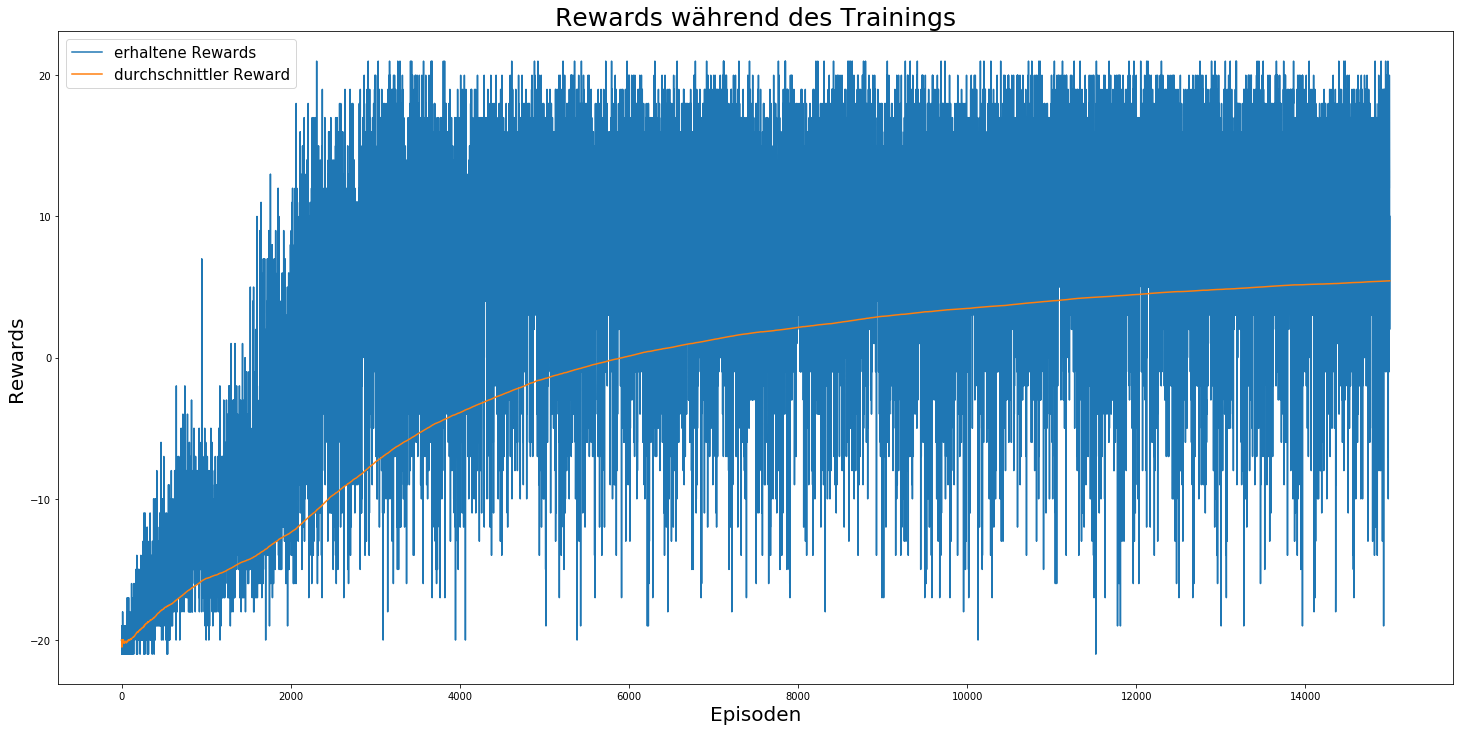

In [24]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [25]:
!ls "WEIGHTS/"

Breakout-v0_DQN_End.h5	     MsPacman-v0_DQN_Ep_1724.h5
Breakout-v0_DQN_Ep_1139.h5   MsPacman-v0_DQN_Ep_4394.h5
Breakout-v0_DQN_Ep_1512.h5   MsPacman-v0_DQN_Ep_6009.h5
Breakout-v0_DQN_Ep_1728.h5   Pong-v0_DQN_End.h5
Breakout-v0_DQN_Ep_1984.h5   Pong-v0_DQN_Ep_11090.h5
Breakout-v0_DQN_Ep_1985.h5   Pong-v0_DQN_Ep_12285.h5
Breakout-v0_DQN_Ep_2810.h5   Pong-v0_DQN_Ep_12286.h5
Breakout-v0_DQN_Ep_4641.h5   Pong-v0_DQN_Ep_13058.h5
MsPacman-v0_DQN_End.h5	     Pong-v0_DQN_Ep_4891.h5
MsPacman-v0_DQN_Ep_13830.h5  Pong-v0_DQN_Ep_9450.h5


In [26]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

OSError: Unable to open file (unable to open file: name = 'WEIGHTS/Pong-v0_DQN_Ep_14840.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Rendering a Game

In [ ]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)